### 2491 - Machine Learning - Prof. Sabina Zejnilovic
Chachanidze, Giorgio (44944) | Dornigg, Thomas (41727) | Rodríguez, Beatriz (40757) | Schwab, Hanna (45166)

**Business Problem**<br>
In today’s financial markets, banks play a crucial role, especially when it comes to the decision on who should be granted a loan and under which market conditions. A major issue which financial institutions have to face in this process is the risk of non-payment of its counterparty, meaning that banks need to pay special attention not to give a loan to risky borrowers. However, since banks have to analyze and process a certain amount of applications every day, this method is time-consuming and the result of the evaluation, when done manually, prone to errors. In this case, the best option for the bank is to evaluate the customer based on its previous credit history in a fully automatic way. To do so, statistical credit scoring algorithms are required to overcome those challenges. These algorithms, which compute probability of defaults for each applicant based on the credit history of its customers, are the main methods which financial institutions nowadays use to determine whether a loan should be granted to a borrower or not.

Regarding the machine learning problem we are facing in this project, since we are trying to build and train a model to predict whether a loan holder should be granted a loan or not, it is clearly a classification problem where we have two different classes to group our data:<br>
- default or <br>
- non default<br>

The data for this project can be found on <a href="https://www.kaggle.com/c/home-credit-default-risk">Kaggle</a>.

In [1]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 }else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Group Project: Credit Risk Modeling

<p align="center">
  <img width="460" height="360" src="https://pngimage.net/wp-content/uploads/2018/06/home-credit-png-5.png">
</p>

#### Libraries

In [2]:
# @hidden
import pandas as pd
import numpy as np
import os
import pickle
import time
from collections import Counter
from io import BytesIO
import requests
import warnings
warnings.filterwarnings("ignore")

# import sklearn packages for modelling
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score
from sklearn.metrics import recall_score,precision_score,f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import missingno as msno
from sklearn.inspection import permutation_importance
from sklearn import metrics
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV

# Import ML-Classifiers
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Data Visualization set up
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import Image, display
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
%matplotlib inline
%config InlineBackend.figure_format='retina'

#setting max number of columns to be displayed to 100, to get a better view.
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

#### Data Import

In order to handle the massive amount of data, the group first downloaded the datasets from Kaggle with the link as provided above. Since we only used the <code>**application_train.csv**</code> dataset, we converted this file in the beginning with the memory reduction function from below, splitted the converted file into two parts and uploaded both to Github.

In [3]:
# @hidden
url_1 = 'https://raw.githubusercontent.com/ThomasD96/NovaSBE_Machine_Learning/main/datasets/home_credit_01.csv'
url_2 = 'https://raw.githubusercontent.com/ThomasD96/NovaSBE_Machine_Learning/main/datasets/home_credit_02.csv'

In [4]:
# @hidden
df1 = pd.read_csv(url_1, index_col = 0, low_memory = True)

In [5]:
# @hidden
df2 = pd.read_csv(url_2, index_col = 0, low_memory = True)

In [163]:
# @hidden
# merge both dataframes
df = pd.concat([df1, df2], 0)

### 1. Memory Reduction

In [7]:
# @hidden
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

### 2. EDA

#### General Information

The dataset is composed of 7 different sources:

- **application_train/application_test**: Contains basic training data with information about each loan application at Home Credit. Each borrower is identified by feature SK_ID_CURR. The training application data comes with the TARGET indicating 0 (the loan was repaid) or 1 (the loan was not repaid).

- **bureau**: Contains data on previous loans in other credit institutions from bureau.

- **bureau_balance**: Consists of monthly data about the previous credits in bureau. Each row displays one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.

- **previous_application**: Previous applications for loans at Home Credit, each is identified by the feature SK_ID_PREV.

- **POS_CASH_BALANCE**: Consists of monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.

- **credit_card_balance**: Monthly data about previous credit cards clients have had with Home Credit. Each row identifies as one month's credit card balance, while one credit card can have multiple rows.

- **installments_payment**: Payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

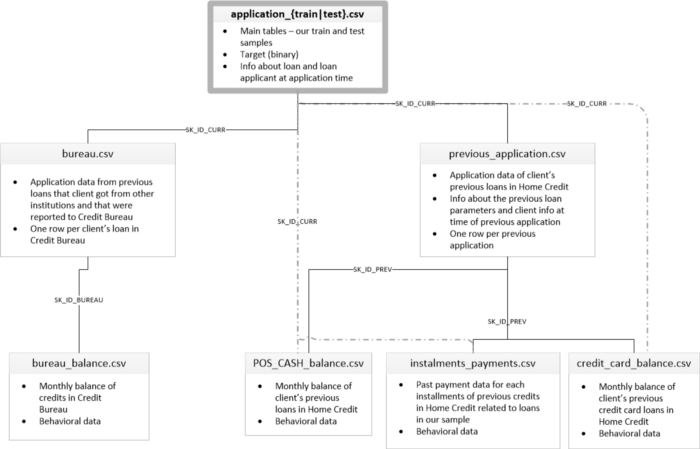
Data Overview

In the following EDA process, the group considers basic statistics and draws graphs to find trends, anomalies, patterns, and relationships within the data. The goal of this EDA is to explore what the data can tell and will follow a top to bottom approach. First, a general overview will identify individual features that draw attention and may be of interest for further analysis. Later, these findings can be used for the construction of the model, the selection of features, and the interpretation of the model.

#### 2.1. Overview and Summary Statistics

**Shape**

- Each row has unique id ‘SK_ID_CURR’ and the output label is in the ‘TARGET’ column.
- TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.

In [164]:
print("The dataset consists of", df.shape[0],'rows and', df.shape[1], 'columns.')

The dataset consists of 307511 rows and 122 columns.


The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the TARGET (the label we want to predict).

**Datatypes**

In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 288.6+ MB


Let's have a closer look at the columns with dtype 'object'. The following cell displays how many unique objects each column contains.

In [166]:
df.select_dtypes('object').nunique()

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

**Descriptive statistics for 'float' variables**

In [167]:
df.select_dtypes('float').agg(['count','min', 'max','mad','mean','median','quantile','kurt','skew','var','std'])

,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,OWN_CAR_AGE,CNT_FAM_MEMBERS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,3.075110e+05,3.075110e+05,3.074990e+05,3.072330e+05,307511.000000,3.075110e+05,104582.000000,307509.000000,134133.000000,3.068510e+05,246546.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
min,2.565000e+04,4.500000e+04,1.615500e+03,4.050000e+04,0.000290,-2.467000e+04,0.000000,1.000000,0.014565,6.000000e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4292.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.170000e+08,4.050000e+06,2.580255e+05,4.050000e+06,0.072500,0.000000e+00,91.000000,20.000000,0.963000,8.550000e-01,0.896000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,348.000000,34.000000,344.000000,24.000000,0.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000
mad,6.622635e+04,3.165837e+05,1.097543e+04,2.885761e+05,0.010293,2.915442e+03,7.669165,0.665870,0.179156,1.571665e-01,0.162631,0.073289,0.052361,0.010979,0.083900,0.042024,0.097881,0.069960,0.116112,0.124602,0.049532,0.061567,0.073569,0.012236,0.036058,0.072433,0.053762,0.011648,0.081316,0.040774,0.095161,0.070237,0.115170,0.123463,0.050118,0.065186,0.073635,0.011474,0.036039,0.073757,0.052248,0.010964,0.083034,0.042122,0.097590,0.070255,0.116547,0.124917,0.050340,0.062354,0.074593,0.012087,0.036391,0.072928,1.655641,0.253930,1.639274,0.183274,696.277280,0.012727,0.013922,0.066518,0.446811,0.429995,1.454803
mean,1.687979e+05,5.990260e+05,2.710

#### 2.2. Missing Values

In [168]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 122, dtype: int64

In [169]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [170]:
missing_data(df).head(10)

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953


Observations:
- Some columns consist of up to 69.9% missing values.
- As we somehow need to handle those missing values, we will investigate how to handle them later on in this analysis.

#### 2.3. Duplicates

In [171]:
# generate a table of culprit rows which are duplicated:
dups = df.groupby(df.columns.tolist()).size().reset_index().rename(columns={0:'count'})

# sum the final col of that table, and subtract the number of culprits:
dups['count'].sum() - dups.shape[0]

0


There are no duplicates in the training set.

#### 2.4. Distribution of Target Column

We will first examine the number of loans falling into each category.

In [172]:
# distribution of target column
df['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

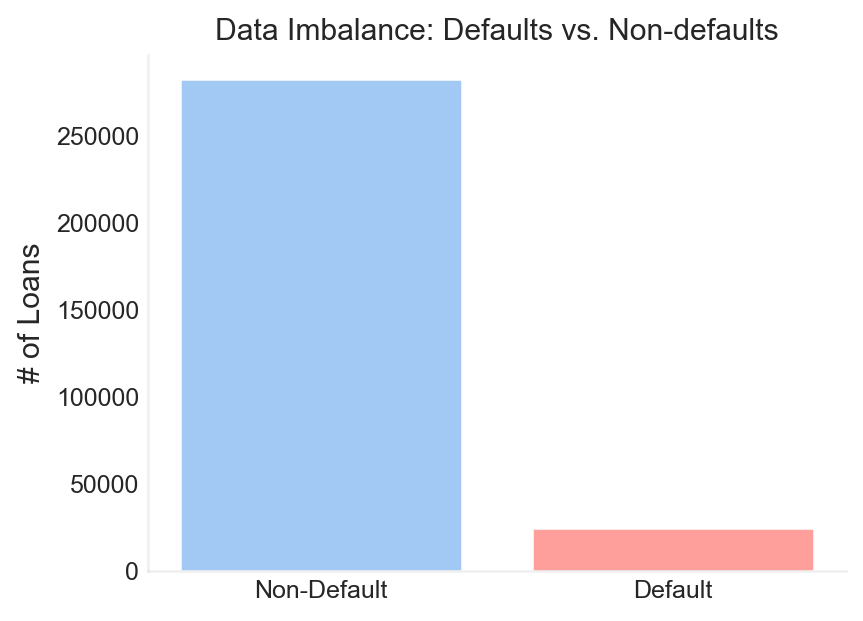

In [173]:
# @hidden
sns.set_style("whitegrid")
plt.figure(figsize=(5,3.8), dpi= 90)
x_values = [0, 1]
labels = ['Non-Default', 'Default']
gender_dist = df.groupby('TARGET').apply(lambda x:x['SK_ID_CURR'].count()).reset_index(name='Counts')
plt.bar(gender_dist['TARGET'], gender_dist['Counts'],color='br')
plt.ylabel('# of Loans',size=12)
plt.title('Data Imbalance: Defaults vs. Non-defaults',size=12)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.3)
plt.tick_params(axis='both', which='major', labelsize=10)
#plt.legend()
plt.xticks(x_values, labels)
plt.show();

Observations:

- The data is imbalanced, with 91.9% of data for repayed loans (0) and 8.07% for loans which have not been repaid (1). The low percentage shows that the firm has already done a great job of minimizing loans with payment difficulties. 
- This is an imbalanced class problem, as there are way more loans that were repaid on time than loans that were not repaid. 
- This has to be taken into account when building the ML-model.

#### 2.5. Distribution of loan types

In [180]:
# distribution of loan types
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = df[feature].value_counts()
    df3 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = df[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df3)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=15)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

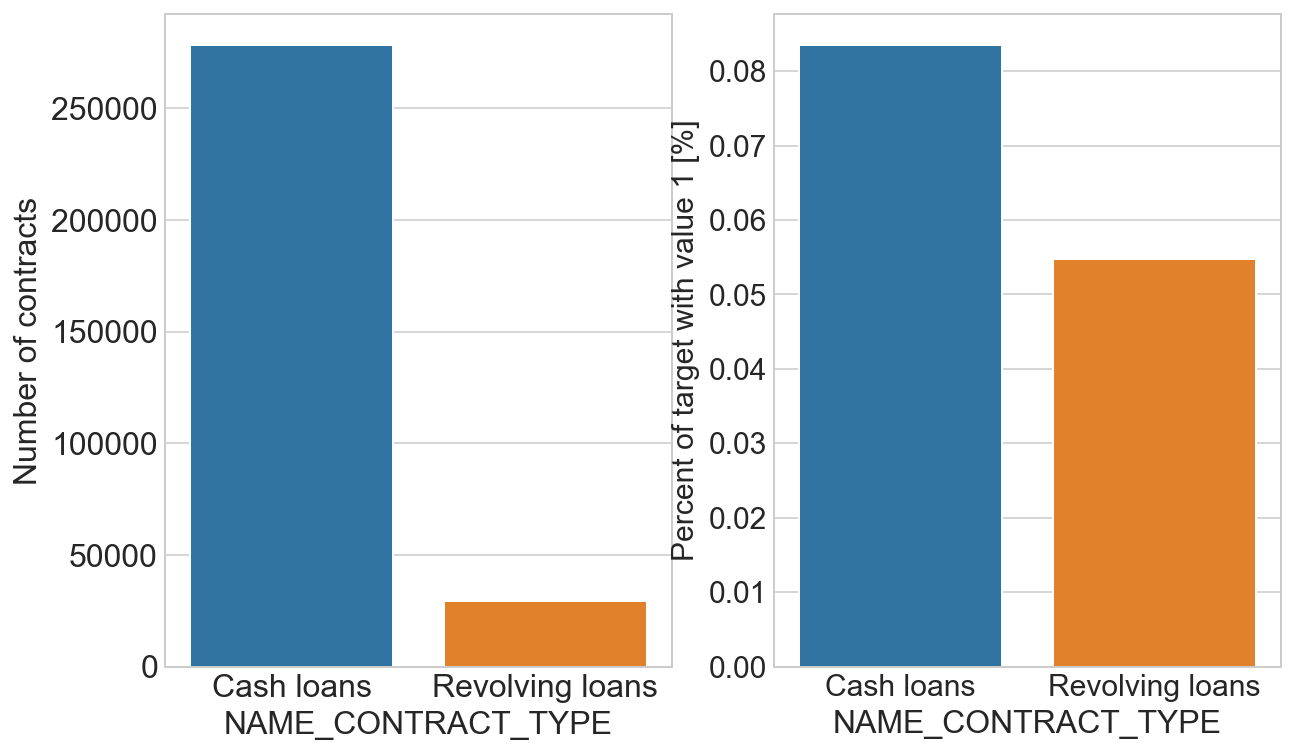

In [181]:
plot_stats('NAME_CONTRACT_TYPE')

Observations:

- Many people are willing to take cash loan than revolving loan.
- Contract type 'Revolving loans' are just a small fraction (10%) from the total number of loans; at the same time, a larger amount of revolving loans, comparing with their frequency, are not repaid.

#### 2.6. Distribution of Income

In [182]:
# The total income value will be split b/w 5 categories to make it easier to use
df['INCOME_VAL'] = pd.cut(df.AMT_INCOME_TOTAL, bins=[0,50000,150000,300000,500000,1000000], labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

In [183]:
df['INCOME_VAL'].value_counts()

Low          150772
Medium       129483
High          20037
Very Low       4517
Very High      2452
Name: INCOME_VAL, dtype: int64

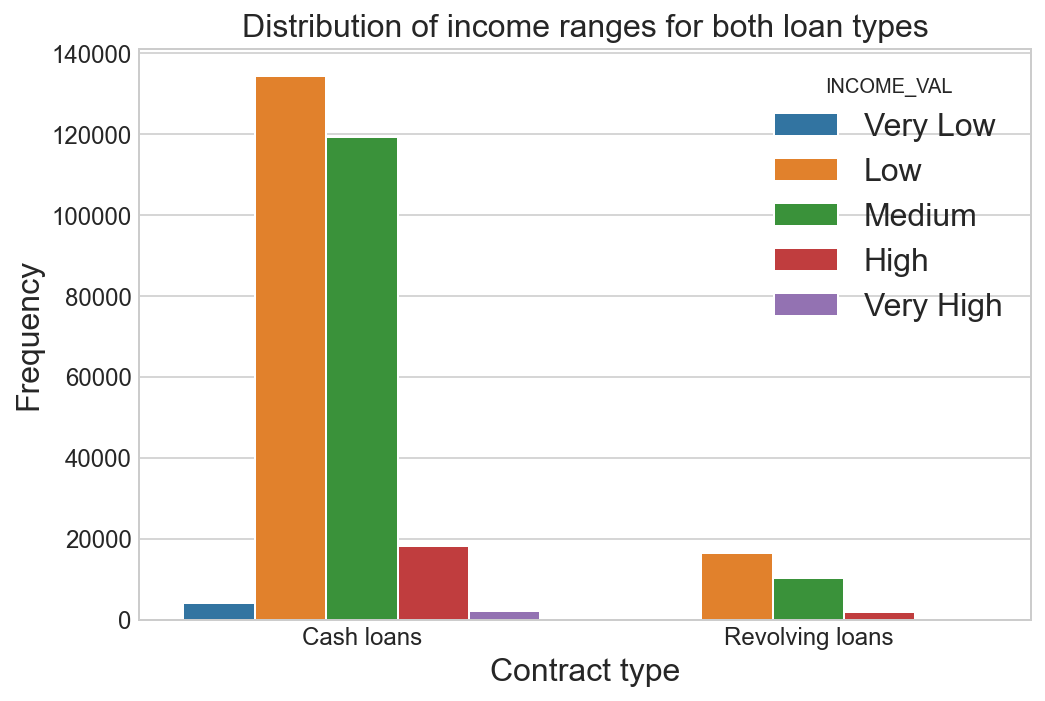

In [206]:
plt.figure(figsize=(8,5.25))
ax_1 = sns.countplot(x='NAME_CONTRACT_TYPE', hue='INCOME_VAL', data= df)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Contract type')
plt.ylabel('Frequency')
plt.title('Distribution of income ranges for both loan types')
plt.show()

Observations:

- People with very high income (>1,000,000) are least likely to take a loan, while people with low income (15,000 - 30,000) are most likely to apply for a loan.
- It makes sense that those on the extremes of the income spectrum would either be unable to secure a loan or not need to secure a loan at all.

**Distribution of Income Sources**

In [185]:
income_val = df['NAME_INCOME_TYPE'].value_counts()

In [186]:
income_val

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

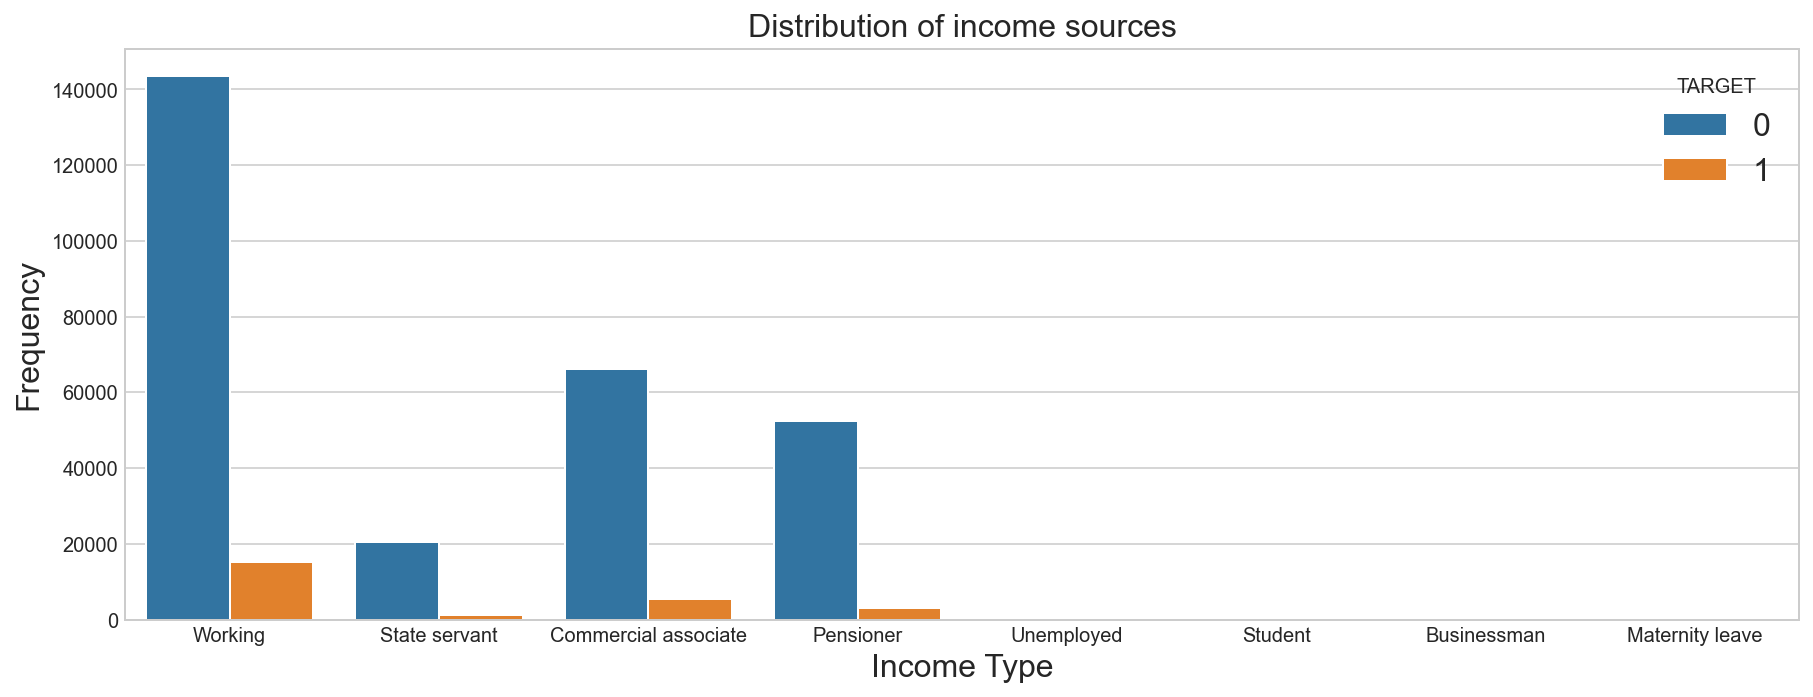

In [187]:
plt.figure(figsize=(15,5.25))
sns.countplot(data = df, x = 'NAME_INCOME_TYPE', hue = 'TARGET')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Distribution of income sources')
plt.xlabel('Income Type')
plt.ylabel('Frequency')
plt.show()

Observations:

- Income types 'Working', 'Commercial Associate' and 'Pensioneer' are the ones that are most likely not repaying their loan.

#### 2.7. Loan Amount Distribution

In the following, we will consider the distribution of loan amounts and their impact on repayment.

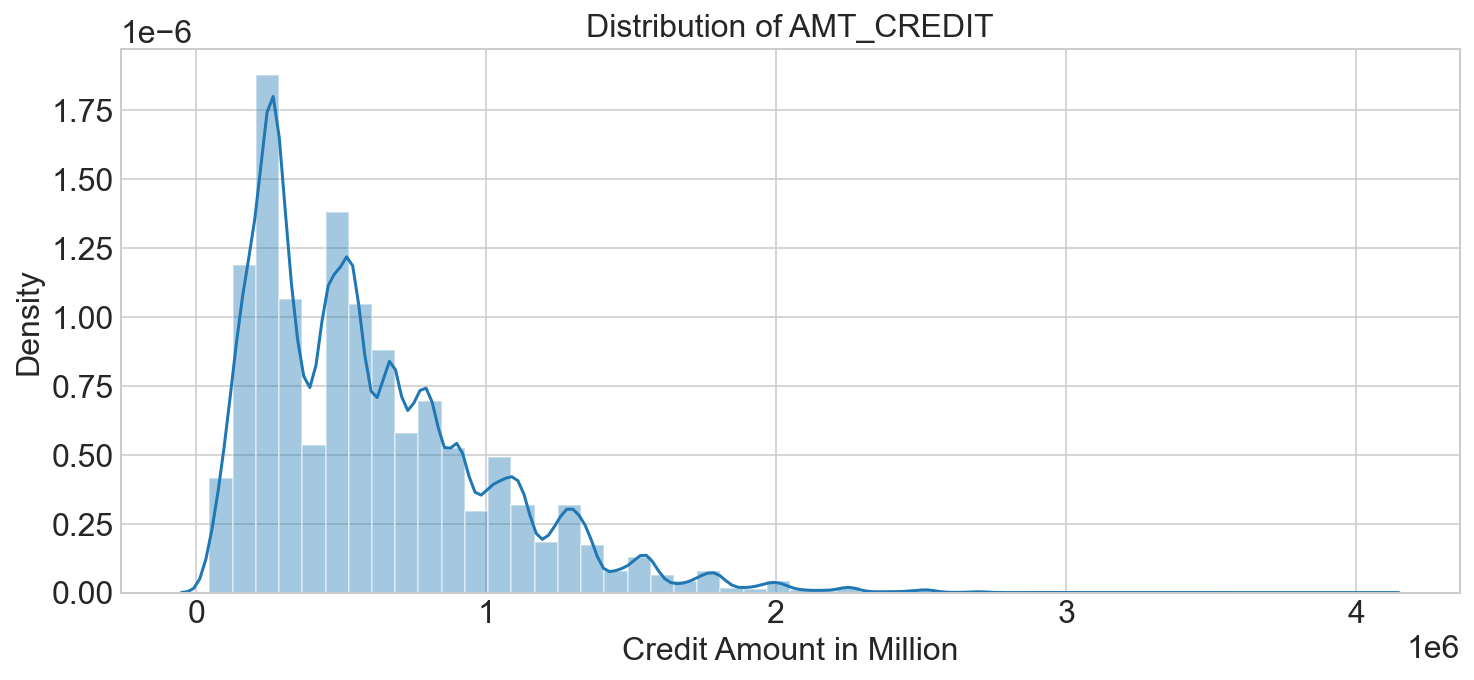

In [188]:
plt.figure(figsize=(12,5))
plt.title("Distribution of AMT_CREDIT")
sns.distplot(df["AMT_CREDIT"])
plt.xlabel('Credit Amount in Million')
plt.title("Distribution of AMT_CREDIT")
plt.show()

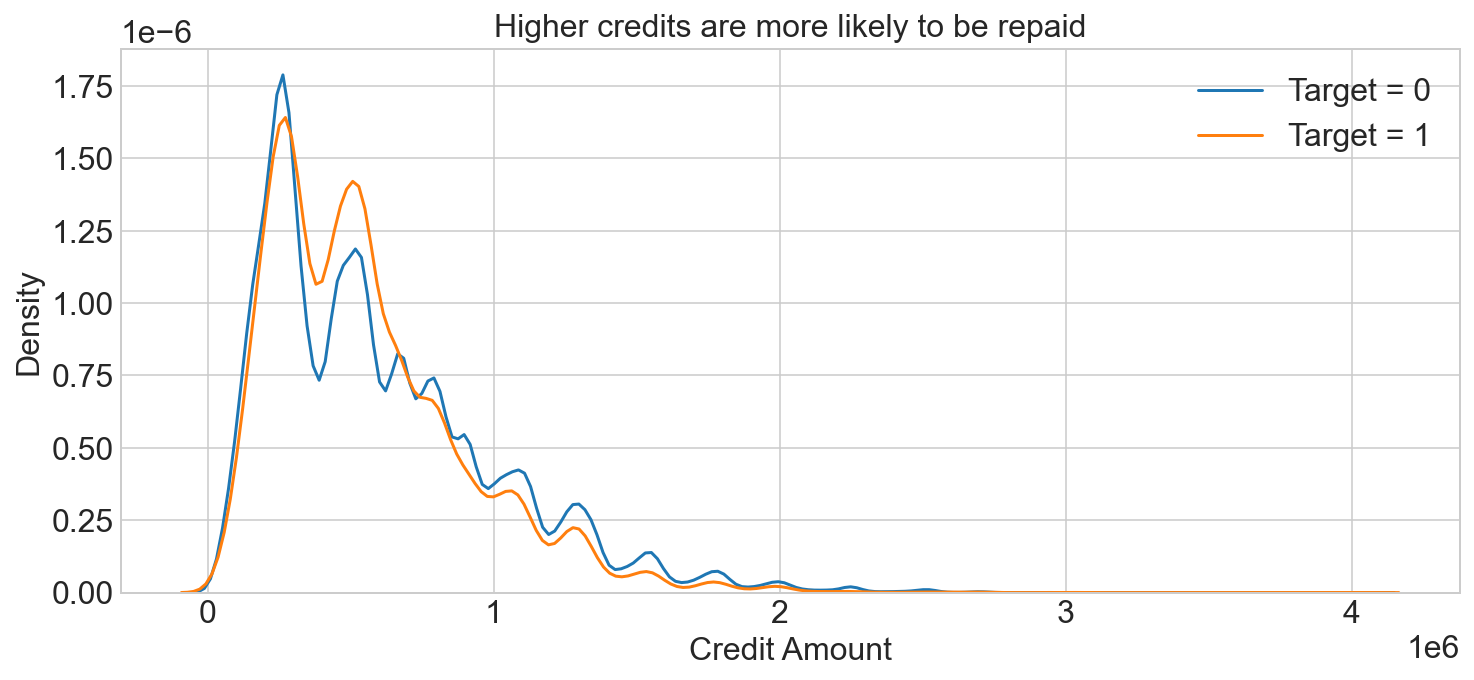

In [189]:
plt.figure(figsize=(12,5))

# KDE target = 0
sns.kdeplot(df.loc[df['TARGET'] == 0, 'AMT_CREDIT'], label = 'target == 0')

# KDE target = 1
sns.kdeplot(df.loc[df['TARGET'] == 1, 'AMT_CREDIT'], label = 'target == 1')

# Labels and legend
plt.legend(labels=['Target = 0', 'Target = 1'])
plt.xlabel('Credit Amount')
plt.title('Higher credits are more likely to be repaid')
plt.show()

Observations:

- As seen in the KDE plot, people who are taking a credit for a large amount are very likely to repay the loan.
- Credits until 500,000 are most likely to not be repaid by the borrower.

#### 2.8. Distribution of Age

It is clear that the older the client, the higher the probability of return (up to a certain limit, of course). However, age is specified on negative days before the loan is issued. In the following, the client age will be calculated based on the DAYS_BIRTH column and then analysed based on age bins and value distribution.

In [190]:
#Converting the values in columns starting with 'DAYS' to absolute
df['DAYS_BIRTH']= abs(df['DAYS_BIRTH'])

In [191]:
print(df.DAYS_BIRTH.unique())

[ 9461 16765 19046 ...  7951  7857 25061]


In [192]:
# Days_birth column has the age of the client in days and the datatype is float
# Converting the age to years and the datatype to int
df.DAYS_BIRTH = ((df.DAYS_BIRTH)/365).astype('int')
df.DAYS_BIRTH.describe()

count    307511.000000
mean         43.435968
std          11.954593
min          20.000000
25%          34.000000
50%          43.000000
75%          53.000000
max          69.000000
Name: DAYS_BIRTH, dtype: float64

In [193]:
#Let's bin the birth data to make it easier to use.
df['DAYS_BIRTH_BINS']=pd.cut(df.DAYS_BIRTH, bins=[18,40,60,100], labels=['Young','Middle_Age','Senior'])
df['DAYS_BIRTH_BINS'].value_counts()

Middle_Age    142220
Young         135923
Senior         29368
Name: DAYS_BIRTH_BINS, dtype: int64

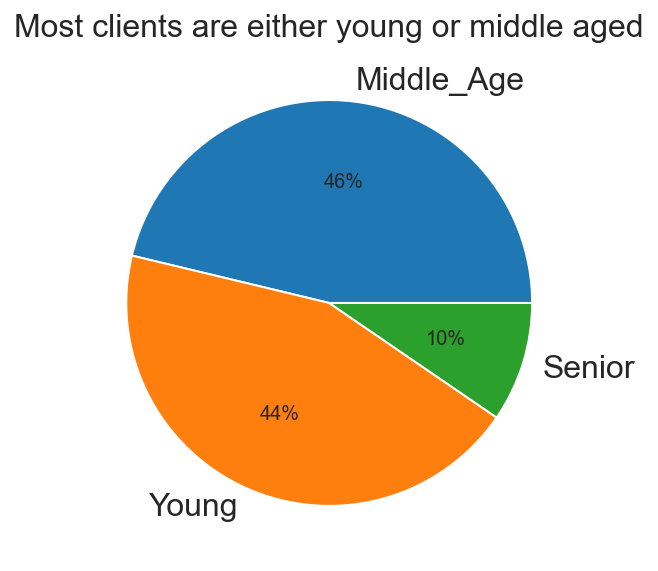

In [195]:
fig =plt.subplots(1,1,figsize=[10,6.18])
plt.subplot(1,2,1)

df.DAYS_BIRTH_BINS.value_counts().plot.pie(autopct='%1.0f%%')
plt.ylabel(' ')
plt.title('Most clients are either young or middle aged')
plt.show()

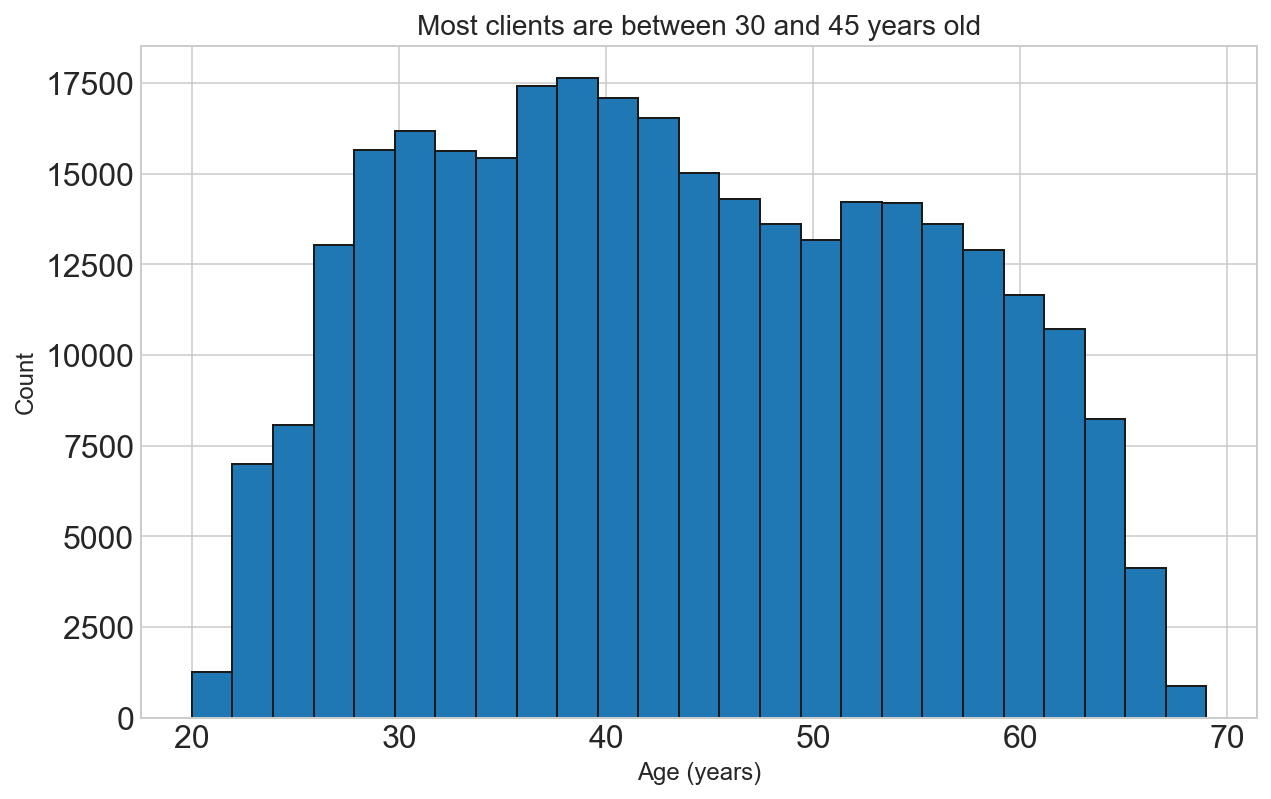

In [196]:
plt.figure(figsize=(10,6.18))
plt.hist(df['DAYS_BIRTH'], edgecolor='k',bins=25)
plt.title('Most clients are between 30 and 45 years old', fontsize = 14)
plt.xlabel('Age (years)', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

The histogram itself may be useful, however, in this case there are no unusual characteristics visible and the distribution looks somewhat reasonable. To show the influence of age on the result, a kernel density estimation (KDE) plot can be created, with the kernel density distribution drawn in the colors of the target feature. It shows the distribution of a variable and can be interpreted as a smoothed histogram (calculated as a Gaussian kernel over each point, which is then averaged to smooth it).

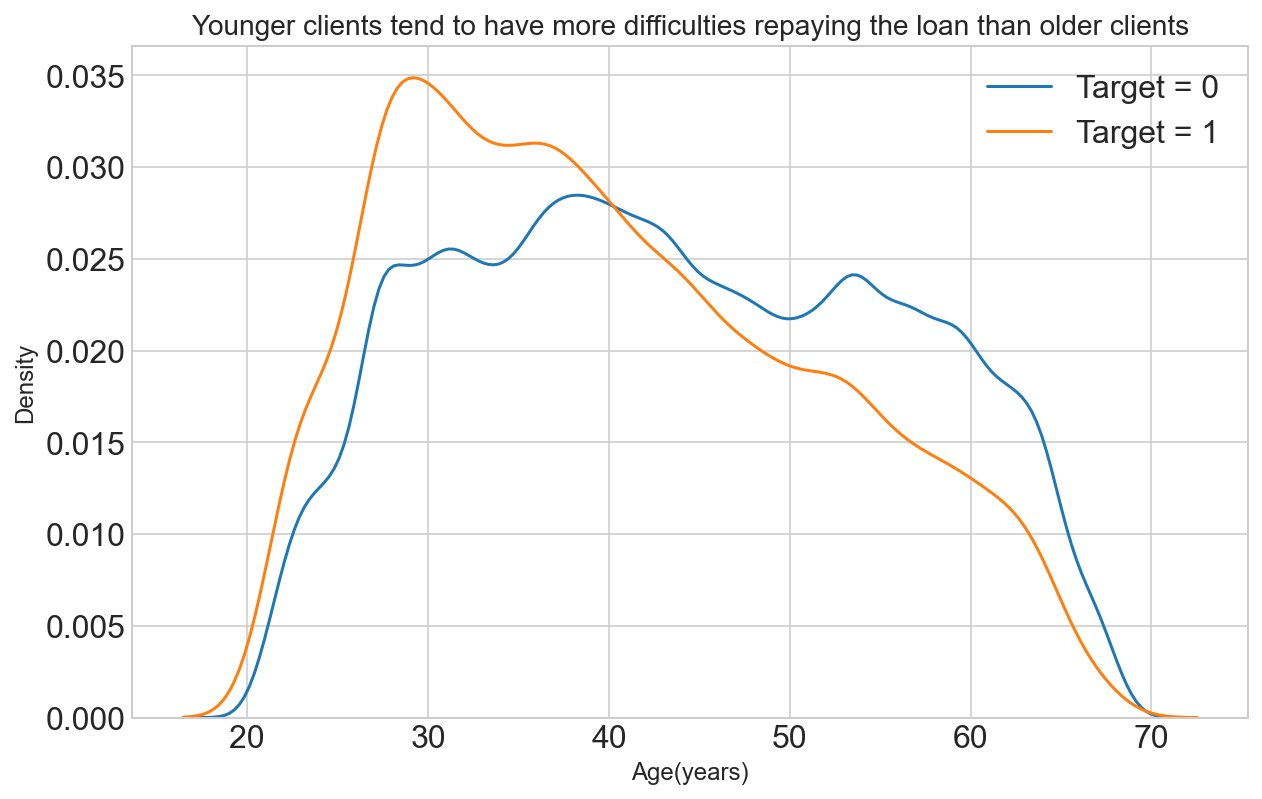

In [197]:
plt.figure(figsize=(10,6.18))

# (TARGET=0)
sns.kdeplot(df.loc[df['TARGET']==0,'DAYS_BIRTH'],label='target==0')

# (TARGET=1)
sns.kdeplot(df.loc[df['TARGET']==1,'DAYS_BIRTH'],label='target==1')

plt.xlabel('Age(years)', fontsize = 12)
plt.ylabel('Density', fontsize = 12)
plt.legend(labels=['Target = 0', 'Target = 1'])
plt.title('Younger clients tend to have more difficulties repaying the loan than older clients', fontsize = 14)

plt.show()

Observations:

- The non-return rate is higher for young people and decreases with increasing age. 
- This should not be a reason to always deny young people a loan, as such a “recommendation” will only lead to a loss of income and market for the bank. 
- Instead, this can rather be seen as an incentive to think about a more thorough tracking of such loans, assessment and, perhaps, even some kind of financial education for young borrowers.

#### 2.9. Clients' Family Background

**Family Status**

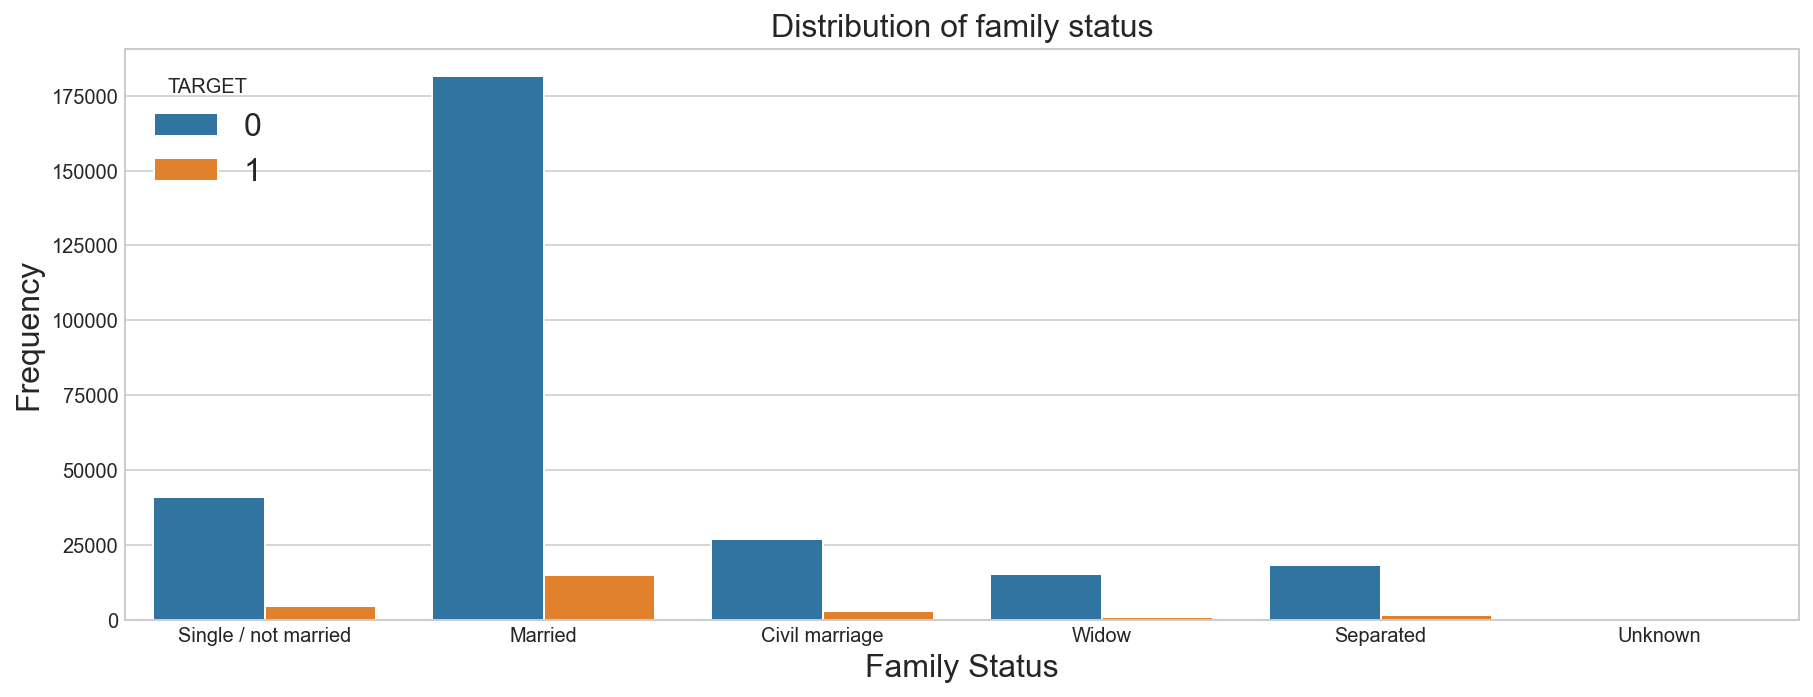

In [198]:
plt.figure(figsize=(15,5.25))
sns.countplot(data = df, x = 'NAME_FAMILY_STATUS', hue = 'TARGET')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Distribution of family status')
plt.xlabel('Family Status')
plt.ylabel('Frequency')
plt.show()

Observations:

- Most of clients are married, which could be explained by the family engagements such as funding house equipment.
- Clients with status Single/not married and civil marriage are also very frequent among borrowers.

**Number of Children**

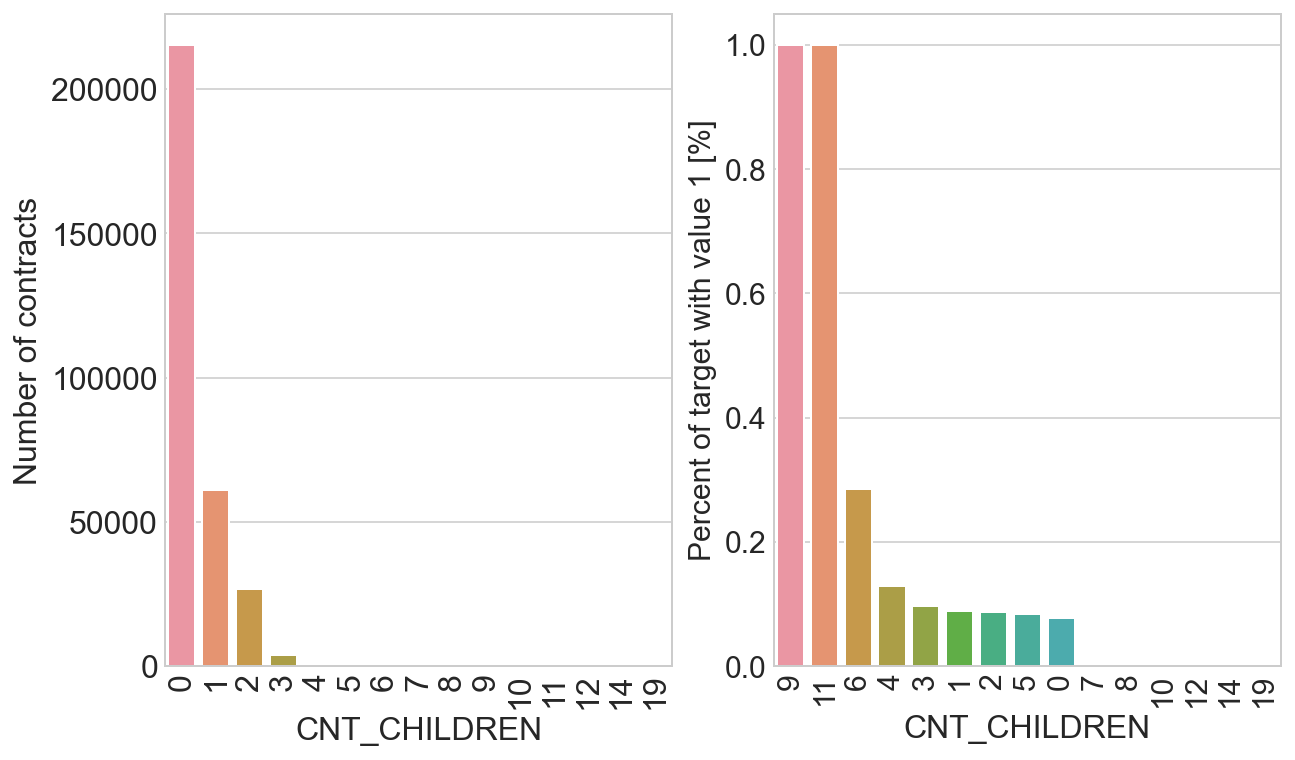

In [199]:
plot_stats('CNT_CHILDREN',True)

Observations:

- Most of the clients taking a loan have no children. 
- Compared with this number, the number of loans associated with the clients with one child is 4 times smaller, the number of loans associated with the clients with two children is 8 times smaller; clients with 3, 4 or more children are much more rare. 
- As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children). As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

**Family Members**

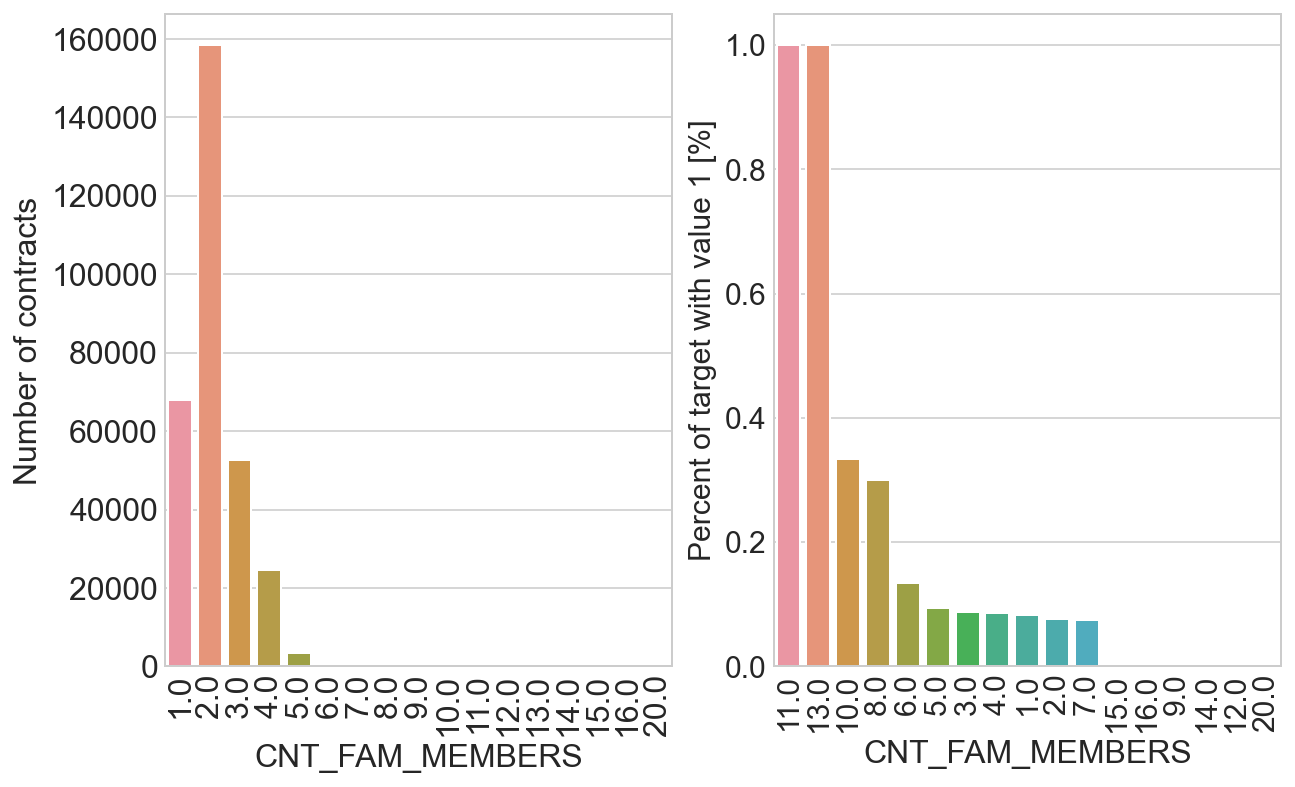

In [200]:
plot_stats('CNT_FAM_MEMBERS',True)

Observations:

- Clients with 2 family members are most common, followed by 1 (single persons), 3 (families with one child) and 4. 100% of clients with family size of 11 and 13 do not repay their loan. 
- Other families with 10 or 8 members show percentages of not repayment of loans over 30%. Families with 6 or less members have repayment rates close to the 10% average.

#### 2.10. Educational Background

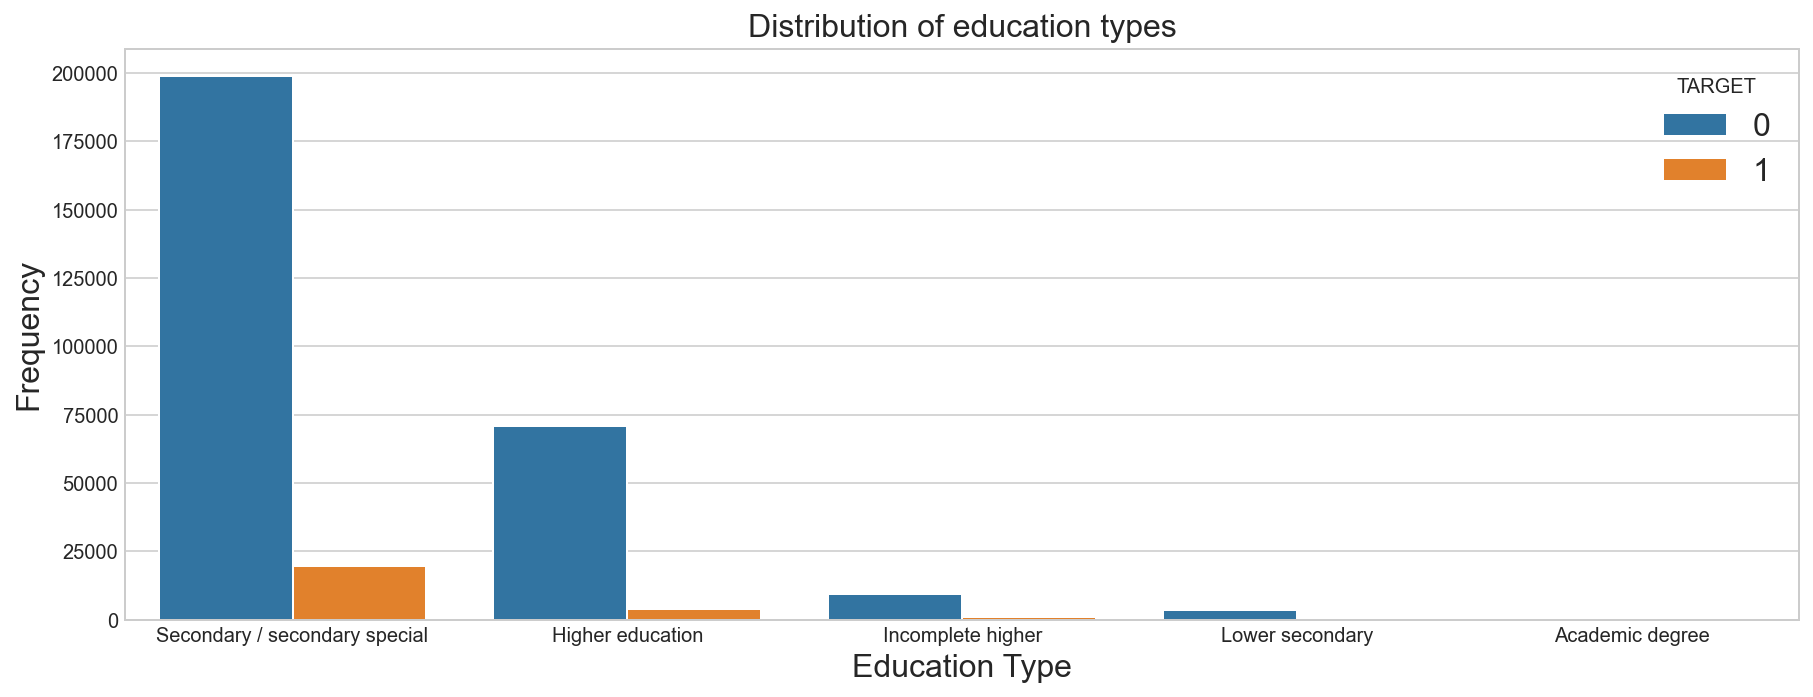

In [201]:
plt.figure(figsize=(15,5.25))
sns.countplot(data = df, x = 'NAME_EDUCATION_TYPE', hue = 'TARGET')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.title('Distribution of education types')
plt.xlabel('Education Type')
plt.ylabel('Frequency')
plt.show()

Observations:

- The majority of the clients have secondary or secondary special education, followed by clients with higher education. 
- Only a very small number of clients are having an academic degree, indicating that those people are more likely to repay their loan.

#### 2.11. Clients' Occupation

**Occupation Type**

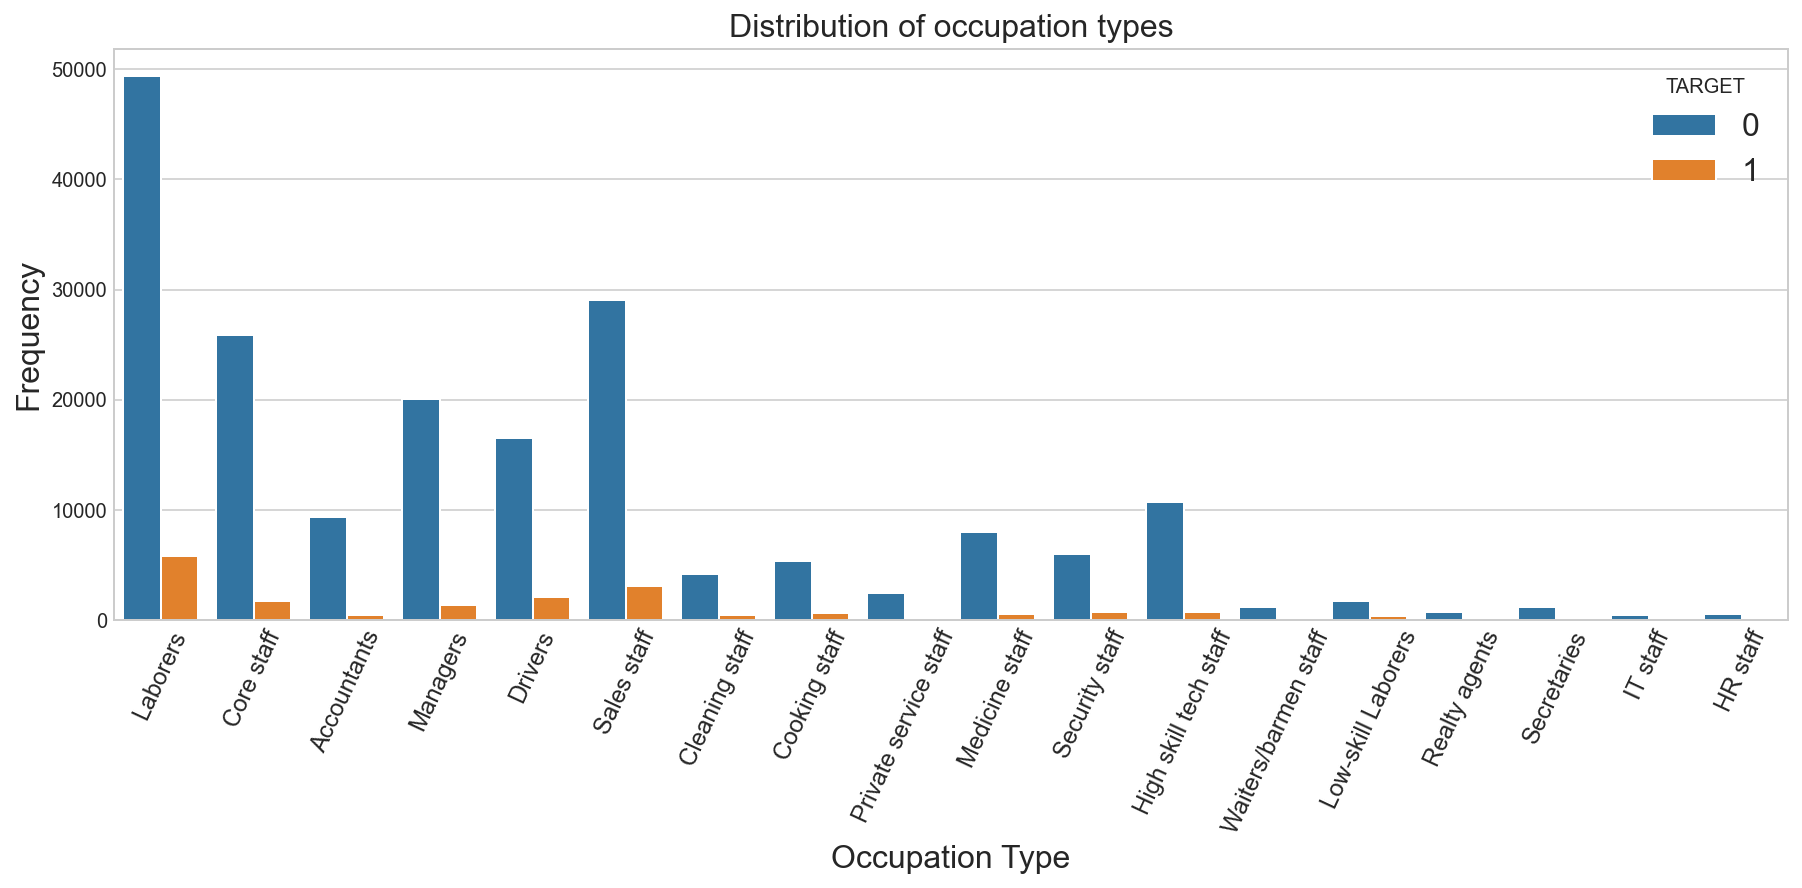

In [202]:
plt.figure(figsize=(15,5.25))
sns.countplot(data = df, x = 'OCCUPATION_TYPE', hue = 'TARGET')
plt.tick_params(axis='x', which='major', labelsize=12, labelrotation = 65)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.title('Distribution of occupation types')
plt.xlabel('Occupation Type')
plt.ylabel('Frequency')
plt.show()

Observations:

- Most of the loans are taken by Laborers, followed by Sales staff. 
- IT and HR staff take loans least frequently.

#### 2.12. Density Distribution of Population

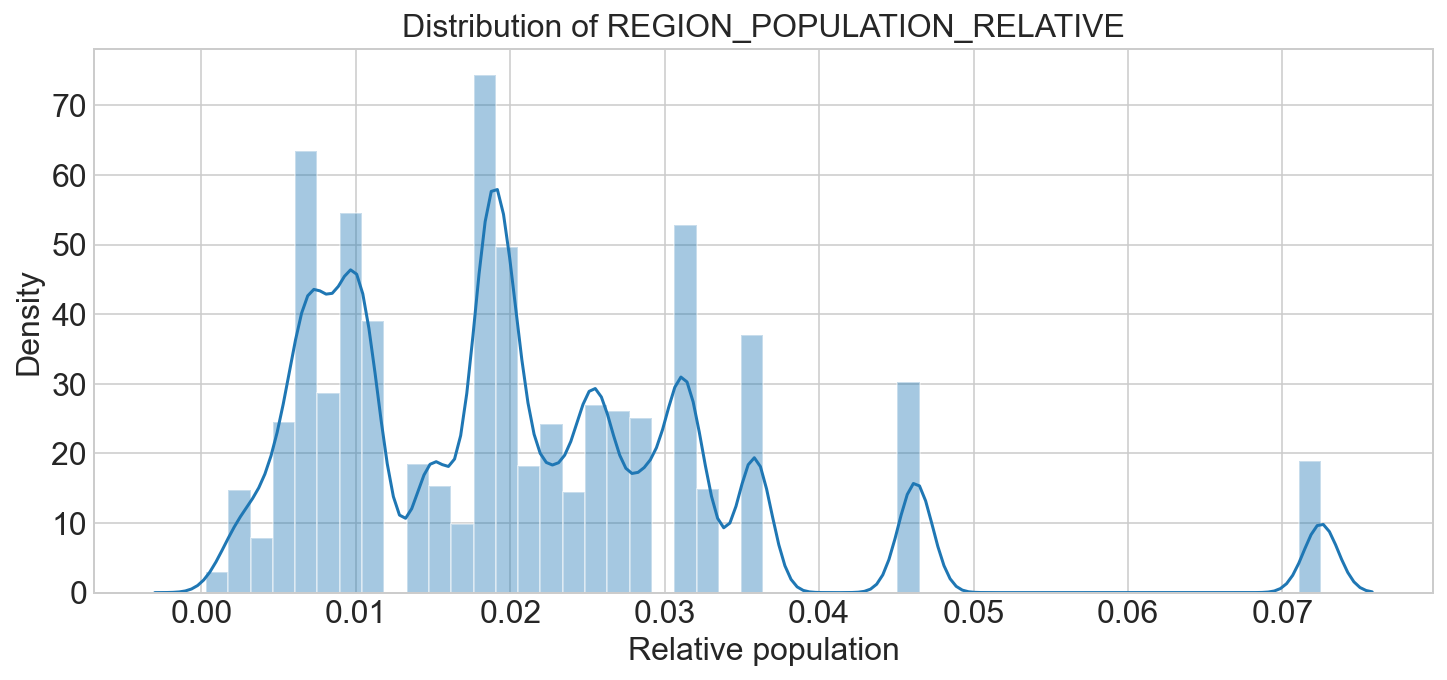

In [203]:
plt.figure(figsize=(12,5))
sns.distplot(df["REGION_POPULATION_RELATIVE"])
plt.xlabel('Relative population')
plt.title("Distribution of REGION_POPULATION_RELATIVE")
plt.show()

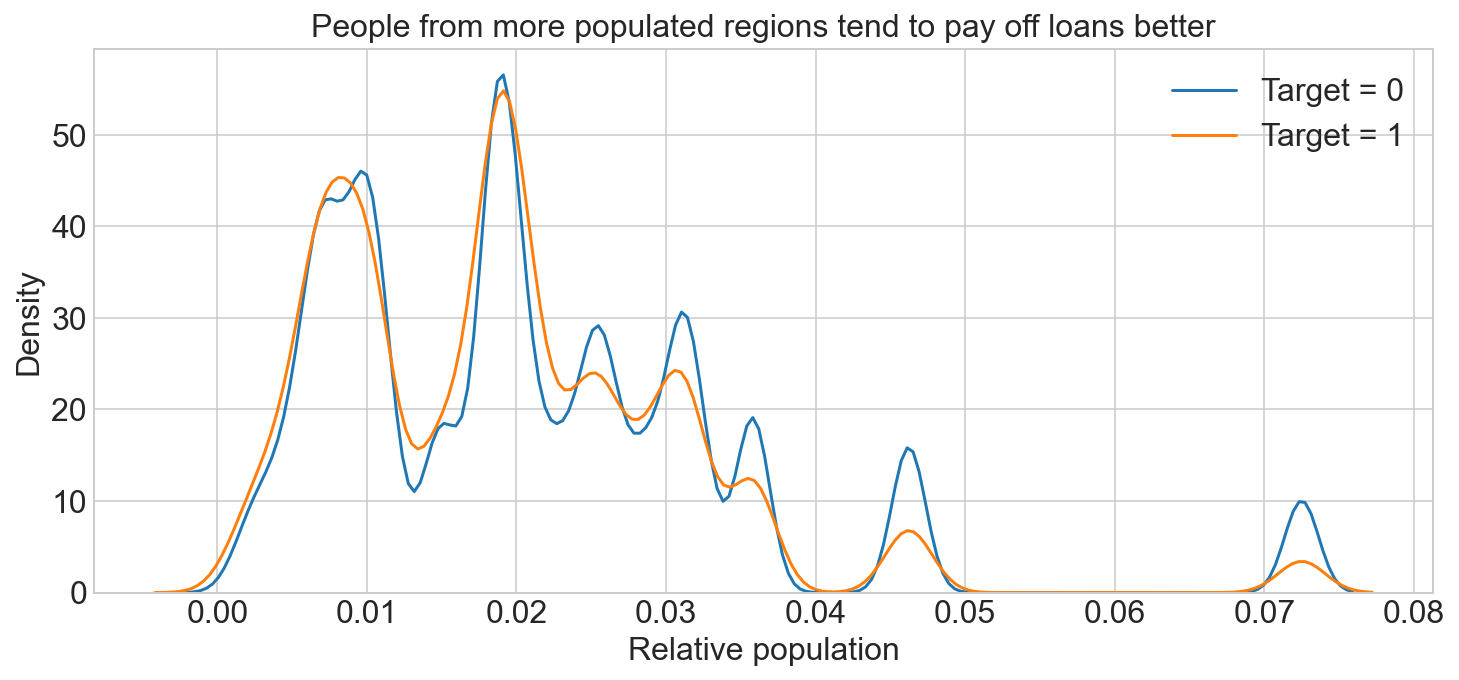

In [204]:
plt.figure(figsize=(12,5))

# KDE for target = 0
sns.kdeplot(df.loc[df['TARGET'] == 0, 'REGION_POPULATION_RELATIVE'], label = 'target == 0')

# KDE for target = 1
sns.kdeplot(df.loc[df['TARGET'] == 1, 'REGION_POPULATION_RELATIVE'], label = 'target == 1')

# Labels and legend
plt.legend(labels=['Target = 0', 'Target = 1'])
plt.xlabel('Relative population')
plt.ylabel('Density')
plt.title('People from more populated regions tend to pay off loans better')
plt.show()

Observations:

- Clients from more populated regions have less difficulties with repaying their loan than customers from more populated regions.

#### 2.13. Correlations

In [131]:
df.corr()
# Comment: As we have 106x106 correlations, we do not visualize it as it would result in a messy heatmap that is impossible to read/analyze.

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,...,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
SK_ID_CURR,1.000000,-0.002108,-0.001129,-0.001820,-0.000343,-0.000433,-0.000232,0.000850,0.001467,0.001366,-0.000973,-0.000384,0.001818,0.002804,-0.001337,-0.000415,0.002815,0.002753,0.000281,-0.002895,-0.001075,-0.001138,0.000350,-0.000283,0.001097,0.002903,-0.001885,-0.001582,0.000067,0.000084,0.002344,0.000220,0.001557,-0.002070,0.001562,0.005905,-0.001463,0.004862,-0.002878,0.004851,0.003082,0.001464,0.003119,0.001770,-0.002576,0.003043,0.001961,-0.001412,0.001900,0.005245,...,0.003588,0.002156,-0.001923,0.001920,0.001988,-0.001647,0.001376,0.005766,-0.001036,0.005067,-0.002582,0.004589,0.002835,0.001698,0.003273,0.002206,-0.003019,0.002441,0.002289,-0.001409,-0.000082,-0.001423,0.001187,-0.000857,0.000700,-0.003411,-0.004139,-0.001097,0.002121,-0.002694,0.001809,0.001505,-0.000815,-0.002012,-0.001045,0.000896,-0.001077,0.002604,-0.000724,0.001450,0.000509,0.000167,0.001073,0.000282,-0.002672,-0.002193,0.002099,0.000485,0.001025,0.004659
TARGET,-0.002108,1.000000,0.019187,-0.003982,-0.030369,-0.012817,-0.039645,-0.037230,-0.078234,-0.044932,0.041975,0.051457,0.037612,0.000534,0.045982,0.028524,0.000370,-0.023806,-0.001758,0.009308,0.058899,0.060893,-0.024166,0.005576,0.006942,0.002819,0.044395,0.050994,0.032518,-0.155318,-0.160471,-0.178918,-0.029498,-0.022746,-0.009757,-0.022150,-0.018549,-0.034199,-0.019172,-0.044003,-0.033615,-0.010885,-0.025031,-0.032998,-0.003176,-0.013579,-0.027284,-0.019952,-0.009058,-0.022070,...,-0.023393,-0.030684,-0.001556,-0.012710,-0.029183,-0.022082,-0.010018,-0.022319,-0.018574,-0.033863,-0.019026,-0.043768,-0.033396,-0.011255,-0.024621,-0.032740,-0.002757,-0.013337,-0.032595,0.009131,0.032248,0.009022,0.031276,0.055219,0.005417,0.044346,-0.002672,-0.000316,-0.028602,-0.001520,-0.008040,-0.004352,-0.001414,-0.004229,-0.000756,-0.011583,-0.009464,-0.006536,-0.011615,-0.003378,-0.007952,-0.001358,0.000215,0.003709,0.000930,0.002704,0.000788,-0.012462,-0.002022,0.019930
CNT_CHILDREN,-0.001129,0.019187,1.000000,0.012882,0.002145,0.021374,-0.001827,-0.025565,-0.330893,-0.239818,0.183396,-0.028019,0.008494,0.001041,0.240714,0.055630,-0.000794,-0.029906,0.022619,0.879161,0.025423,0.024781,-0.007292,-0.

In [132]:
# Check correlation of features with the target variable
corr_matrix = df.corr().abs()
print(corr_matrix['TARGET'].sort_values(ascending=False).head(10))

TARGET                         1.000000
EXT_SOURCE_3                   0.178918
EXT_SOURCE_2                   0.160471
EXT_SOURCE_1                   0.155318
DAYS_BIRTH                     0.078234
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055219
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
Name: TARGET, dtype: float64


Observations:

- Besides the features 'EXT_SOURCE_3', 'EXT_SOURCE_2' AND 'EXT_SOURCE_1', the target variable shows the most correlation with age and the region the client is living in.
- Further, in section 3.3. collinear features are identified and removed based on a threshold 0.9 to reduce complexity.

#### 2.14. Summary

The EDA showed what the borrowers look like socio-economically. Most borrowers are ranged from lower to middle income and have secondary education. These borrowers are more likely to be married or be in a relationship at the time of securing the loan. Cash loans are the most popular loan type, favored by the lower and middle class earners. Most loans are given to middle-aged or younger people, while the non-return rate is higher for young people and decreases with increasing age. Moreover, people from less populated regions tend to have less problems with repaying their loan, than clients living in more populated regions. The correlation matrix showing the relationships between the target variable and the features confirms this observation.

Looking at the distribution of the target column, the data is highly imbalanced with around 90% of the clients repaying their loan, while only a small fraction (10%) of the clients was not able to repay the loan. While cash loans were more popular amongst borrowers, a larger amount of revolving loans was not repaid, compared to their frequency. Further, clients borrowing large amounts of money are more likely to also pay back their loan. 

### 3. Data Processing

#### 3.1. Missing values in the datasets

In [6]:
# @hidden
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = (mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1))

    # Print some summary information
    print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
          "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [7]:
missing_values_table(df)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


#### 3.2. Missing value handling

When having missing values in a feature, we face a tradeoff between the risk of losing a meaningful feature for our model that has a lot of missing data and inaccurate representation of the feature by imputing a large percentage of the feature's values. Usually, features that have more than 20-30% of missing data should be discarded, however, you should think about the relevance of each feature that is being dropped beforehand. As we face 106 features that are fairly complex to evaluate, we choose a higher threshold of 50%, this way accounting for the fact that we may drop features that are important but have a lot of missing data. We will use imputation to fill in the values where necessary.

In [8]:
# @hidden
# data collection issue ---> why?
# which type of customer/wrong with data collection process
# comment why 50%?? Play around with it. Suggested are 20-30% but can be tested against 50% by comparing their model performance.
missing_values = missing_values_table(df).reset_index()
missing_values_cols = missing_values[missing_values['Missing Values'] > 50]
missing_values_cols = missing_values_cols['index'].to_list()

# drop columns where NaN > 50%
df_after = df.drop(missing_values_cols, axis = 1)
print ('Dataset before deletion of missing values: {}'.format(df.shape))
print ('Dataset after deletion of missing values: {}'.format(df_after.shape))

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.
Dataset before deletion of missing values: (307511, 122)
Dataset after deletion of missing values: (307511, 58)


#### 3.3. Remove collinear features based on threshold

(Play around with different thresholds!) Collinearity occurs when two features show a linear assocaition between each other. This implies that they roughly yield the same information and keeping both of them, does not add predictive power for our model. When features are highly correlated, generally, with a coefficient higher than 0.7, the generalization performance and interpretability of the established model decreases, which is why we want to avoid it. We will remove features that have a correlation coefficient of 0.9 or higher to focus on only the strongest correlations.

In [9]:
# @hidden
# min/max
df_before_drop = df_after.copy()
correlated_features = set()
correlation_matrix = df_after.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
#These are the features that will be dropped.
df_after.drop(labels=correlated_features, axis=1, inplace=True)
print ('Dataset before dropping collinear-features: {}'.format(df_before_drop.shape))
print ('Dataset after dropping collinear-features: {}'. format(df_after.shape))

Dataset before dropping collinear-features: (307511, 58)
Dataset after dropping collinear-features: (307511, 56)


#### 3.4. Cardinality of the non-numeric features

Cardinality is the number of unique values that a categorical feature has. Let’s have a look at it for our training dataset:

In [10]:
# Add more about CArdinality - why did we do it? Whats the purpose? 
# https://towardsdatascience.com/building-an-automated-machine-learning-pipeline-part-one-5c70ae682f35
def get_cardinality (df):
    object_columns = (df.select_dtypes(include="object").columns)
    for column in object_columns:
        print("{} has {} unique values.".format(column, df[column].nunique()))
get_cardinality(df_after)

NAME_CONTRACT_TYPE has 2 unique values.
CODE_GENDER has 3 unique values.
FLAG_OWN_CAR has 2 unique values.
FLAG_OWN_REALTY has 2 unique values.
NAME_INCOME_TYPE has 8 unique values.
NAME_EDUCATION_TYPE has 5 unique values.
NAME_FAMILY_STATUS has 6 unique values.
NAME_HOUSING_TYPE has 6 unique values.
WEEKDAY_APPR_PROCESS_START has 7 unique values.
ORGANIZATION_TYPE has 58 unique values.


We can infer that a feature has a<br>
- high cardinality if it has more than X rows out of Y: 
- moderate cardinality if it has more than X rows: 
- low cardinality if it has less than X rows: 

High cardinality features may cause problems when we are training our model. Even though we transform each unique value of a categorical feature to a new feature, they may bring the curse of dimensionality. So, we are going to use the high cardinality features for adding new features, then we are going to remove them from the datasets.

Remember that this is a sample dataset. So we cannot guarantee that we have seen all the possible values of each categorical feature when we are training the model. If our wine rating predictor encounters with a new value in the test set, it will throw errors. That is why we are going to revisit this in the Feature Engineering & Pre-processing.

### 4. Feature Engineering

#### 4.1. Create new (manual) features

In [11]:
# shape before
print ('Dataset before adding new variables: {}'.format(df_after.shape))

# additional features for train-set
df_after['CREDIT_INCOME_PERCENT'] = df_after['AMT_CREDIT'] / df_after['AMT_INCOME_TOTAL']
df_after['ANNUITY_INCOME_PERCENT'] = df_after['AMT_ANNUITY'] / df_after['AMT_INCOME_TOTAL']
df_after['CREDIT_TERM'] = df_after['AMT_ANNUITY'] / df_after['AMT_CREDIT']

# shape after
print ('Dataset after adding new variables: {}'.format(df_after.shape))

Dataset before adding new variables: (307511, 56)
Dataset after adding new variables: (307511, 59)


#### 4.2. Reduce rows by taking a sample from the original dataset

We tried to run the ML-models in section 5 with the full dataset (307511 rows, 59 columns), however, we constantly got an "out of memory error". Thus, we tried to reduce our dataset by a half by taking a stratified-sample, meaning we are keeping the same balance between defaults and non-defaults.

In [157]:
# @ hidden
# compute distributions of defaults & non-defaults of original dataframe
non_defaults_original = df_after.TARGET.value_counts()[0]
defaults_original = df_after.TARGET.value_counts()[1]
combined_original = df_after.shape[0]
print ('Non-Defaults in original dataset: {}'.format(non_defaults_original/combined_original))
print ('Defaults in original dataset: {}'.format(defaults_original/combined_original))
print ('Shape of original dataframe: {}'.format(df_after.shape))

Non-Defaults in original dataset: 0.9192711805431351
Defaults in original dataset: 0.08072881945686496
Shape of original dataframe: (307511, 59)


In [158]:
# @hidden
# make a equally-weighted sample from the original dataframe (50% of original)
sample_df = df_after.groupby('TARGET').apply(lambda x: x.sample(frac=0.50)).reset_index(1).drop(['TARGET', 'level_1'], 1).reset_index()

# compute distributions of defaults & non-defaults of sampled dataframe
non_defaults_sample = sample_df.TARGET.value_counts()[0]
defaults_sample = sample_df.TARGET.value_counts()[1]
combined_sample = sample_df.shape[0]
print ('Non-Defaults in sampled dataset: {}'.format(non_defaults_sample/combined_sample))
print ('Defaults in sampled dataset: {}'.format(defaults_sample/combined_sample))
print ('Shape of sampled dataframe: {}'.format(sample_df.shape))

Non-Defaults in sampled dataset: 0.9192741699456928
Defaults in sampled dataset: 0.08072583005430718
Shape of sampled dataframe: (153755, 59)


Additionally, in order to have a proper holdout set for the ML-modeling part in the end, the group is using the rest of the 50% (difference between the whole dataset and the sampled dataset) as test set holdout set. Also, we checked if the this dataset has the same distribution of defaults and non-defaults as the other two datasets. 

In [159]:
# holdout-set
a_index = df_after.set_index(['SK_ID_CURR']).index
b_index = sample_df.set_index(['SK_ID_CURR']).index
mask = ~a_index.isin(b_index)
validation_set = df_after.loc[mask]

# compute distributions of defaults & non-defaults of sampled dataframe
non_defaults_validation = validation_set.TARGET.value_counts()[0]
defaults_validation = validation_set.TARGET.value_counts()[1]
combined_validation = validation_set.shape[0]

print ('Non-Defaults in the validation dataset: {}'.format(non_defaults_validation/combined_validation))
print ('Defaults in the validation dataset: {}'.format(defaults_validation/combined_validation))
print ('Shape of the validation dataset: {}'.format(validation_set.shape))

Non-Defaults in the validation dataset: 0.9192681911600198
Defaults in the validation dataset: 0.08073180883998023
Shape of the validation dataset: (153756, 59)


#### 4.3. Train-Test Split

Before setting up the pipeline, we are splitting the data into a train and test set so that we can validate the performance of the model.

In [63]:
# @hidden
X = sample_df.drop(['TARGET', 'SK_ID_CURR'], axis=1)
y = sample_df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2021, stratify=y)
print(X_train.shape)
print(X_test.shape)

(115316, 57)
(38439, 57)


#### 4.4. Preprocessing Pipeline: Transformers

However, in a typical machine learning workflow you will need to apply all these transformations at least twice. Once when training the model and again on any new data you want to predict on. Of course you could write a function to apply them and reuse that but you would still need to run this first and then call the model separately. Scikit-learn pipelines are a tool to simplify this process. They have several key benefits:

- They make your workflow much easier to read and understand.
- They enforce the implementation and order of steps in your project.
- These in turn make your work much more reproducible

https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

The first step in building the pipeline is to define each transformer type. The convention here is generally to create transformers for the different variable types. In the code below I have created a numeric transformer which applies a StandardScaler, and includes a SimpleImputer to fill in any missing values. This is a really nice function in scikit-learn and has a number of options for filling missing values. I have chosen to use median but another method may result in better performance. The categorical transformer also has a SimpleImputer with a different fill method, and leverages OneHotEncoder to transform the categorical values into integers.

The permutation based importance can be used to overcome drawbacks of default feature importance computed with mean impurity decrease. It is implemented in scikit-learn as permutation_importance method. As arguments it requires trained model (can be any model compatible with scikit-learn API) and validation (test data). This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one.

From the previous data exploration, we know that the target distribution in the training data is highly imbalanced. The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important [2]. There are many approaches one can use to overcome this issue: <br>
- oversample the minority class (oversampling)
- duplicating examples in the minority class (undersampling)
- Synthetic Minority Oversampling Technique (SMOTE) which synthesizes new examples from already existing examples

In general, SMOTE is an oversampling technique where the synthetic samples are generated for the minority class. This algorithm helps to overcome the overfitting problem posed by random oversampling. It focuses on the feature space to generate new instances with the help of interpolation between the positive instances that lie together [5][6]. In the beginning of this project, the group tried to run different models without any sampling-techniques and as expected, due to the imbalanceness of the dataset, we received bad results. Thus, for the following, we will make use of the SMOTE library and we will try to investigate, if the model performance can be increased.

In [68]:
# https://medium.com/user-pipeline/machine-learning-feature-encoding-with-onehotencoder-inside-a-pipeline-76d440940f4b
# https://medium.com/@oluwabukunmige/logistic-regression-in-scikit-learn-a-step-by-step-process-32f546241f32
# https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = df_after.select_dtypes(include=np.number).drop(['TARGET', 'SK_ID_CURR'], 1).columns
categorical_features = df_after.select_dtypes(exclude=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

smt = SMOTE(random_state = 2021)
rfe = RFE(estimator=RandomForestClassifier(n_estimators = 50, random_state = 2021), n_features_to_select=40)

#### 4.5. Principal Component Analysis (PCA)

Principal Component Analysis or PCA is a statistical procedure that allows us to summarize / extract the only important data that explains the whole dataset. By using PCA in practice one has the ability to estimate how many components are needed to describe the data. As a result, the principal components are new variables that are constructed as linear combinations or mixtures of the initial variables. These combinations are done in such a way that the new variables (i.e., principal components) are uncorrelated and most of the information within the initial variables is squeezed or compressed into the first components. Below, a bar chart is showing the size of each of the principal components. It helps us to visualize the percentage of variation captured by each of the principal components.

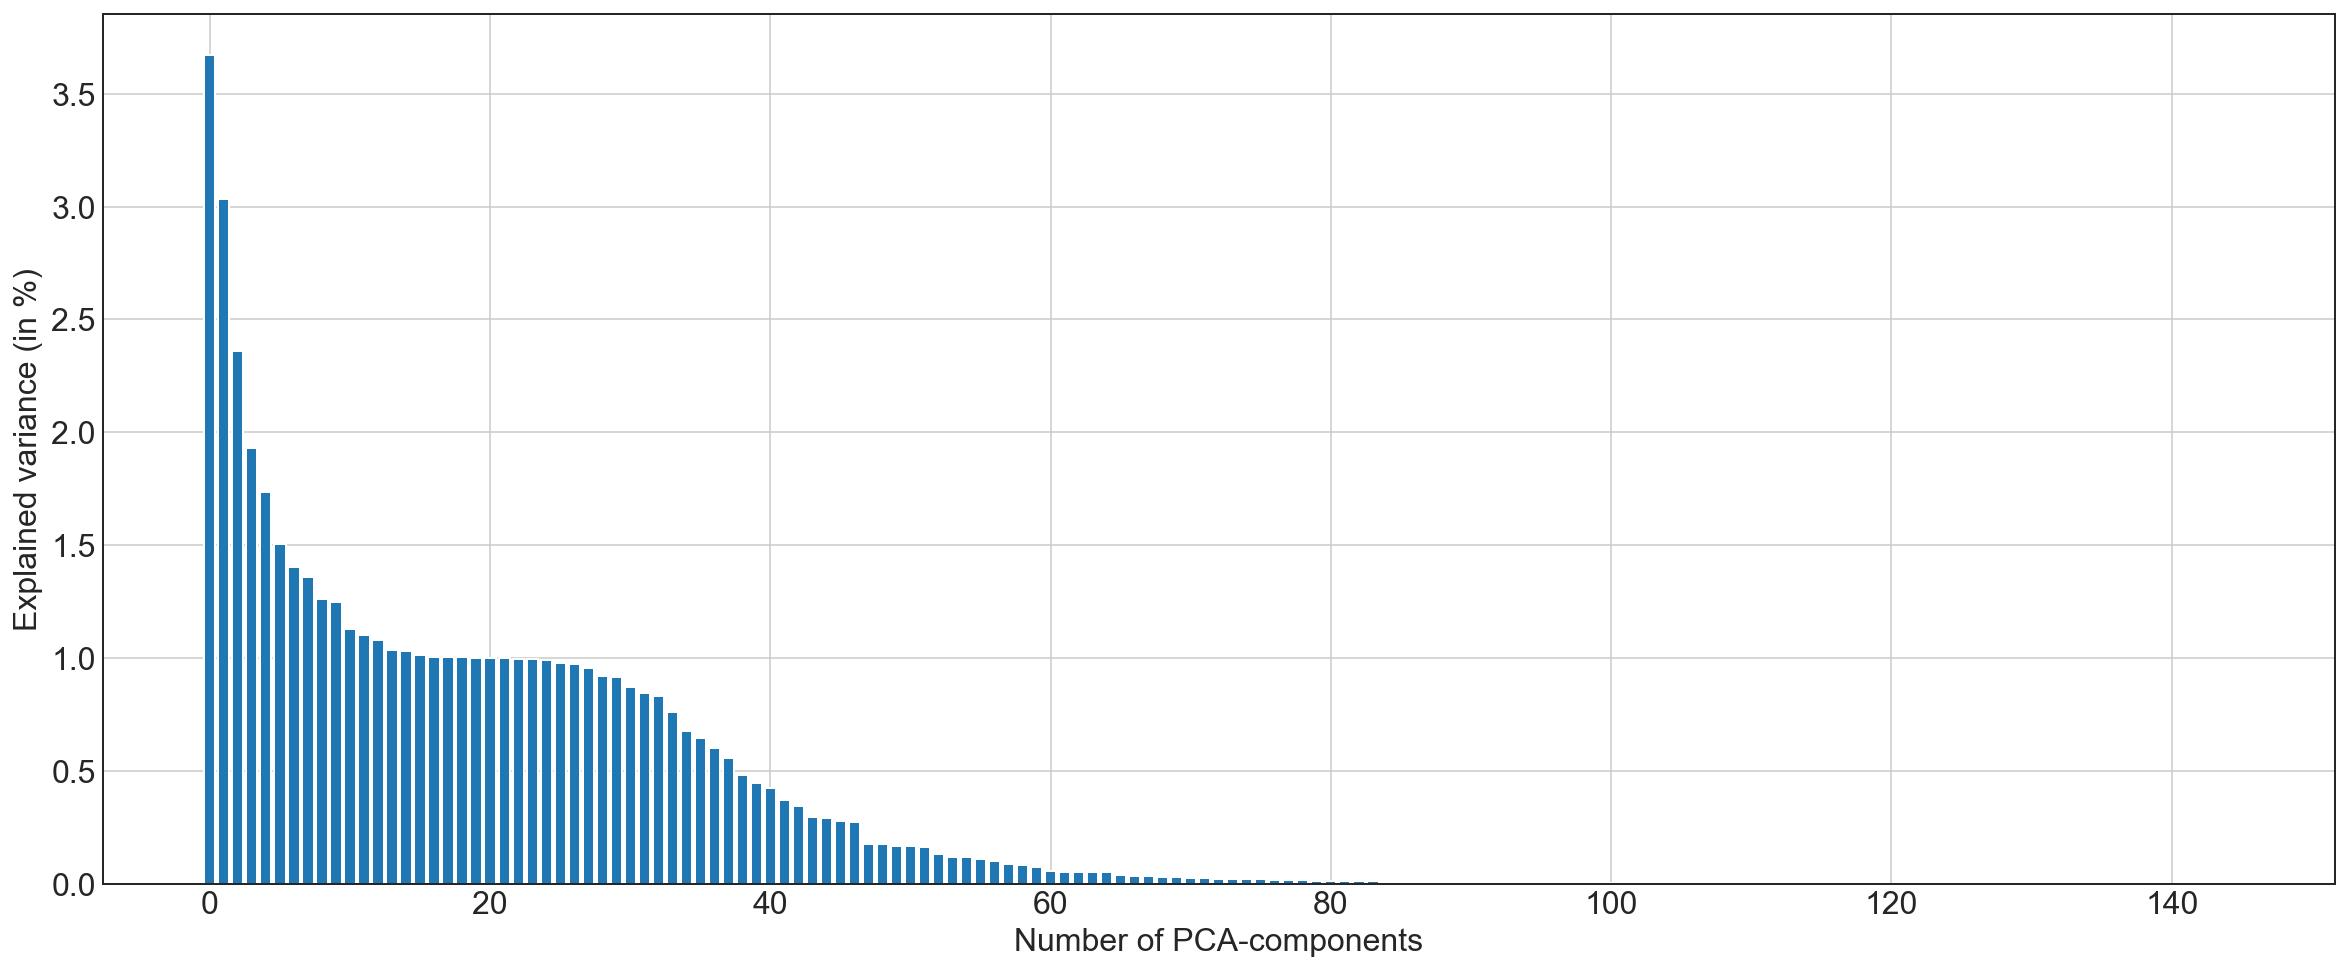

In [222]:
pca = PCA(random_state=2021)
X_train_pca = pca.fit_transform(preprocessor.fit_transform(X_train))
X_test_pca = pca.transform(preprocessor.transform(X_test))
pca.n_components = X_train_pca.shape[1]
components_amount = X_train_pca.shape[1]
pca_data = pca.fit_transform(X_train_pca)
plt.rcParams["figure.figsize"] = (20,8)
plt.bar(range(pca.n_components_), pca.explained_variance_)
plt.xlabel('Number of PCA-components')
plt.ylabel('Explained variance (in %)')
plt.grid()
plt.show()

By looking at the plot above, one can see that for instance the first two principal components explain over 6.50% of the variation in the data. Here, the group chose the amount of components in such a way so that in total we have an explained variance of ca. 90%. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components. A general rule of thumb is to take number of principal of principal components that contribute to significant variance and ignore those with diminishing variance returns, which can be shown in the following graph:

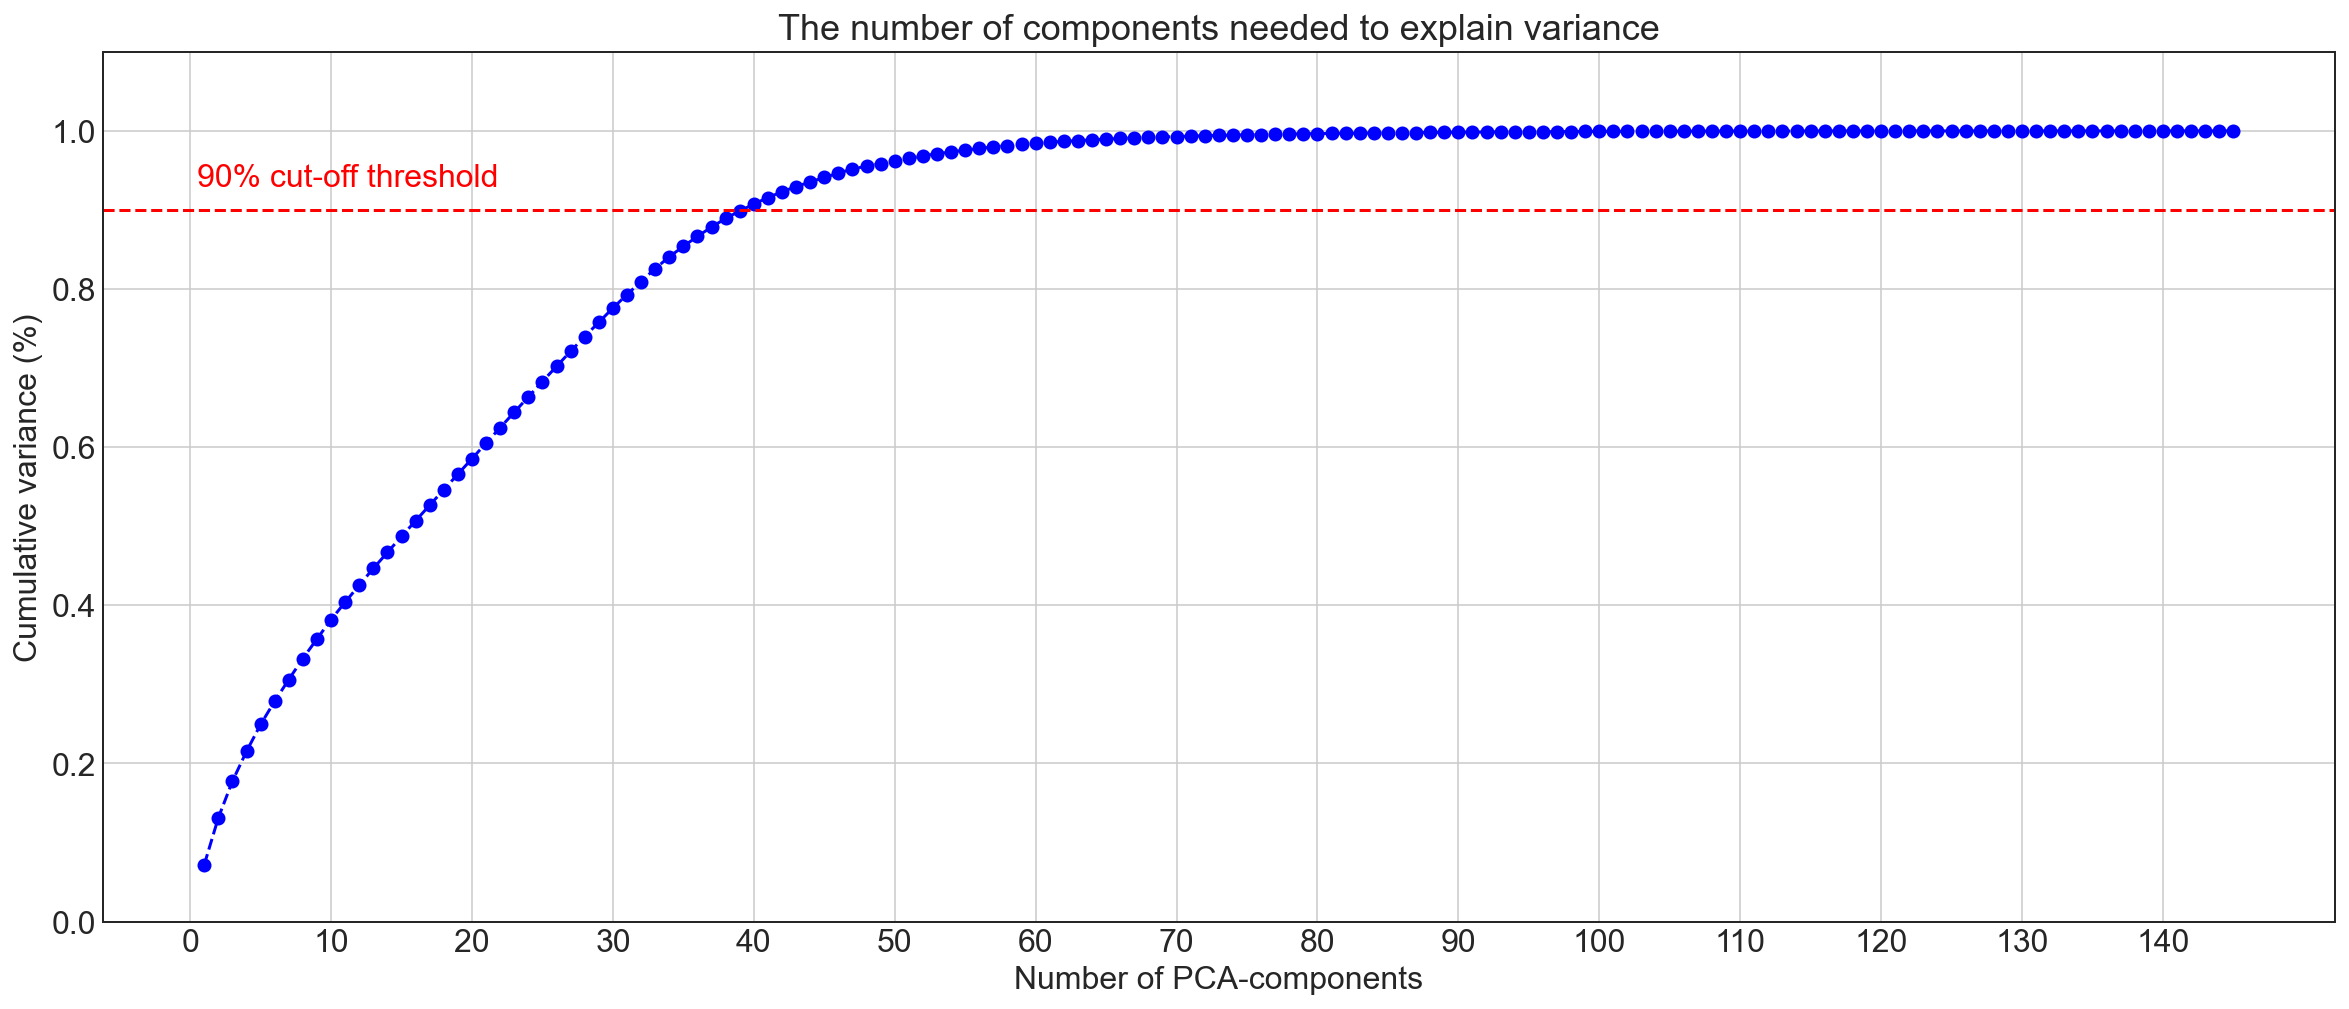

In [223]:
plt.rcParams["figure.figsize"] = (20,8)
fig, ax = plt.subplots()
xi = np.arange(1, components_amount+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)
plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle = '--', color='b')
plt.xlabel('Number of PCA-components')
plt.xticks(np.arange(0, components_amount, step=10)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance', fontsize=18)
plt.axhline(y=0.90, color='r', linestyle='--')
plt.text(0.5, 0.93, '90% cut-off threshold', color = 'red', fontsize=16)
plt.grid()
plt.show()

Thus, it can be seen that 90% of the variance in the data can be achieved with roughly n = 40 principal components.

#### 4.6. Preliminary Result

We completed the first three steps of a machine learning pipeline. After defining the problem and objectives, we <br>

- **1.** Cleaned data by removing redundant and collinear features; and duplicate rows<br>
- **2.** Explored data to have a detailed understanding of the target, features and their relationships<br>
- **3.** Added more useful features (hopefully!), prepared and transformed both datasets<br>

We also completed the crucial step of creating a validation set from the training set. The second article will show how to select an evaluation metric, establish a baseline, select an ML model and tune its hyperparameters by optimizing the selected model’s evaluation metric (steps 4, 5 and 6).

### 5. ML-Modelling

As Andrew mentioned in his lecture, it is important that we choose the right metric when we're optimizing the model. Given that our goal is to predict potential future loan-defaults, following trade-off must be considered:

- **True positive:**  the model said they would default, and they did
- **False positive:**  the model said they would default, and they didn't
- **True negative:**  the model says they would not default, and they wouldn't
- **False negative:**  the model says they would not default, and they would

Clearly, we want to maximize **True Positives**.  When we consider our two errors, which is more costly?  Arugably, it is the **False Negative**.

Therefore, it makes sense to use a performance metric, that when the model has many **True Positives** will be high, but that will be penalized for having too many **False Negatives**. The group also checked this on Stackoverflow, and came to the same conclusion: if the cost of having False negative is high, we want to increase the model's sensitivity and recall [7].

For instance, in fraud detection or sick patient detection, we don't want to label/predict a fraudulent transaction (True Positive) as non-fraudulent (False Negative). Also, we don't want to label/predict a contagious sick patient (True Positive) as not sick (False Negative). This is because the consequences will be worse than a False Positive (incorrectly labeling a a harmless transaction as fraudulent or a non-contagious patient as contagious).

As a result, we can choose to look to the performance metric recall (also called sensitivity or hit rate), for which the formula is: **TP / (TP + FN)**.

Applying ML-models is only one side of the medal, the other, by far the most important one is to tune the models. Thus, in the following, the group summarized the most important steps in this process:
1. Define a model.<br>
2. Define the range of possible values for all hyperparameters.<br>
3. Define evaluative criteria to judge the model.<br>
4. Define a cross-validation method.

The overall aim of hyperparameter tuning is to optimize the performance of the model based on a certain metric. For example, Root Mean Squared Error (RMSE) for regression problems and recall score for our classification problem. There are several approaches to hyperparameter tuning. In this course-project, we will only apply and focus on the **RandomizedSearch**.

As the name implies, this method searches the hyperparameter space randomly for the best performance. This makes it fast and less computationally expensive. Instead of providing a set of values, we provide a statistical distribution for each hyperparameter. First implemented by Bergstra and Bengio, random search has been proven to outperform grid search [2].

In [88]:
# @hidden
###### define functions for evaluation later ######

# confusion-matrix function
def confusion_matrix_normalized (y_test, y_pred):
    plt.rcParams["figure.figsize"] = (10,7)
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    categories = ['No Default','Default']
    return sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories)

# for finding the best threshold (1)
def makePredThresh(fittedCls, thr = 0.5, X_test=X_test):
    prob = fittedCls.predict_proba(X_test)[: ,1]
    final = []
    for p in prob:
        if p >= thr:
            final.append(1)
        else:
            final.append(0)
    
    return final

# for finding the best threshold (2)
def threshold_optimizer (y_test, model_proba):
    
    # Create the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model_proba)

    # Plot the ROC curve
    df_fpr_tpr = pd.DataFrame({'FPR':fpr, 'TPR':tpr, 'Threshold':thresholds})

    # Calculate the G-mean
    gmean = np.sqrt(tpr * (1 - fpr))

    # Find the optimal threshold
    index = np.argmax(gmean)
    thresholdOpt = round(thresholds[index], ndigits = 4)
    gmeanOpt = round(gmean[index], ndigits = 4)
    fprOpt = round(fpr[index], ndigits = 4)
    tprOpt = round(tpr[index], ndigits = 4)
    print('Best Threshold: {} with G-Mean: {}'.format(thresholdOpt, gmeanOpt))
    print('FPR: {}, TPR: {}'.format(fprOpt, tprOpt))
    return thresholdOpt

#### 5.1. Logisitc Regression

In [90]:
# https://stackoverflow.com/questions/41899132/invalid-parameter-for-sklearn-estimator-pipeline
# https://www.tomasbeuzen.com/post/scikit-learn-gridsearch-pipelines/
# https://www.kdnuggets.com/2018/01/managing-machine-learning-workflows-scikit-learn-pipelines-part-2.html
# https://iaml.it/blog/optimizing-sklearn-pipelines
logreg = LogisticRegression(max_iter=5000, random_state=2021)
clf_logreg = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('logreg', logreg)])

params_logreg = {'logreg__C':[0.01, 0.1, 1, 5, 10, 20, 30], 
                 'logreg__penalty':['l2','l1'],
                 'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
                }

clf_logreg = RandomizedSearchCV(estimator=clf_logreg, 
                            param_distributions = params_logreg, 
                            cv=5, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)
clf_logreg.fit(X_train, y_train);

print('Final score on training-set is: ', clf_logreg.score(X_train, y_train))
print('Final score on test-set is: ', clf_logreg.score(X_test, y_test))
print (' ')
print('\nBest params:\n', clf_logreg.best_params_)

KeyboardInterrupt: 

In [82]:
final_model_logreg = clf_logreg.best_estimator_
print("Report:")
logreg_pred = final_model_logreg.predict(X_test)
logreg_accuracy = round(metrics.accuracy_score(y_test, logreg_pred),4)
print ('The Accuracy of the LR-model is: {}'.format(logreg_accuracy))
print (' ')
print(classification_report(y_test, logreg_pred))

Report:
The Accuracy of the LR-model is: 0.6188
 
              precision    recall  f1-score   support

           0       0.95      0.62      0.75     35336
           1       0.12      0.59      0.20      3103

    accuracy                           0.62     38439
   macro avg       0.53      0.61      0.48     38439
weighted avg       0.88      0.62      0.71     38439



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 12%, a recall rate of 59% and an accuracy score of 62%. To refresh our knowledge of precisin, recall and accuracy, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

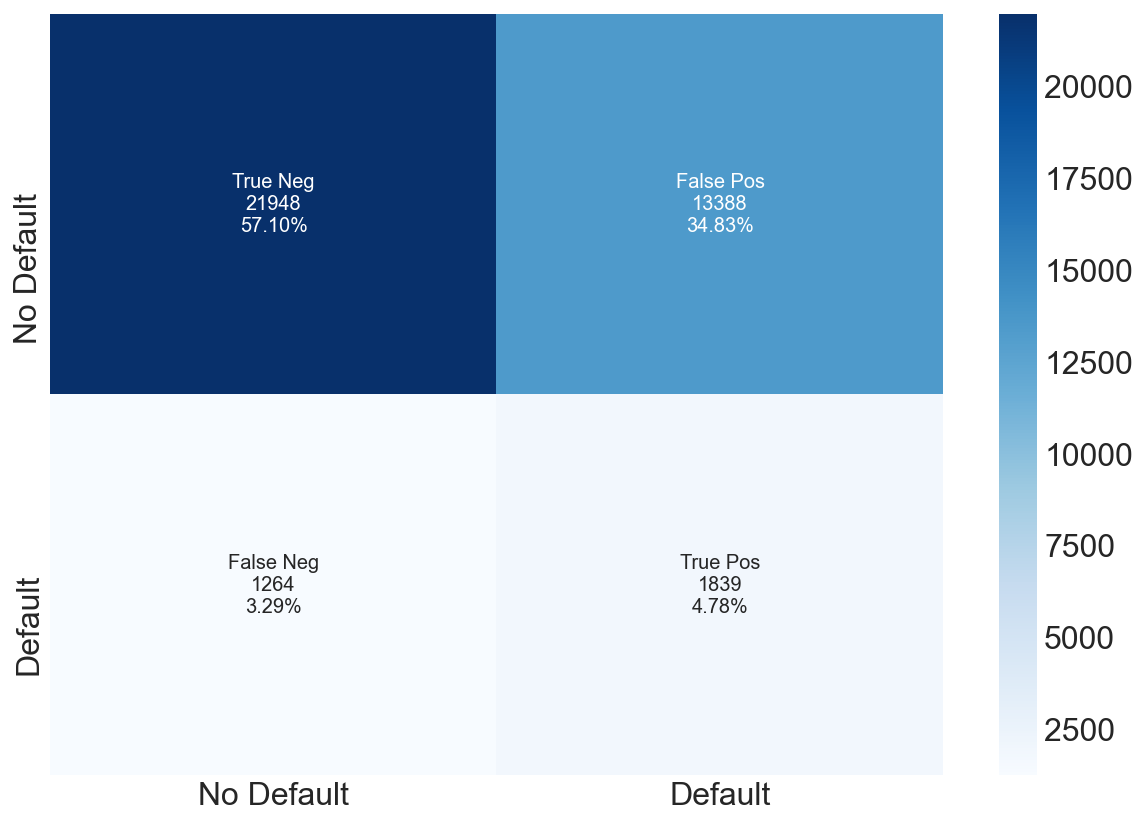

In [138]:
confusion_matrix_normalized(y_test_smote, logreg_pred);

From the confusion matrix, we have 13.388 (34.83%) false positives. This means that our model predicted that 13.388 people won’t pay back their loans whereas these people actually paid. This is actually bad for the bank because we will be turning down people that can actually pay back their loans which will mean that we will be loosing a huge percentage of our potential customers. Our model also has 1264 false negatives. This means that our model predicted that these 1264 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.2. AdaBoost

In [146]:
ada_boost = AdaBoostClassifier(random_state = 2021)
clf_ada = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('clf', ada_boost)])

params_ada = {
    'clf__n_estimators': [20, 50, 70, 100],
    'clf__learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    }

clf_ada = RandomizedSearchCV(estimator=clf_ada, 
                            param_distributions = params_ada, 
                            cv=5, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)

clf_ada.fit(X_train, y_train);

print('Final score on training-set is: ', clf_ada.score(X_train, y_train))
print('Final score on test-set is: ', clf_ada.score(X_test, y_test))
print (' ')
print('\nBest params:\n', clf_ada.best_params_)

Final score on training-set is:  0.7778493930604791
Final score on test-set is:  0.7705446342249436
 

Best params:
 {'clf__n_estimators': 100, 'clf__learning_rate': 0.0001}


In [149]:
final_model_ada = AdaBoostClassifier(random_state=2021, n_estimators = 100, learning_rate = 0.0001)
clf_ada = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('catb', final_model_ada)])
clf_ada.fit(X_train, y_train)
print("Report:")
ada_pred = clf_ada.predict(X_test)
ada_accuracy = round(metrics.accuracy_score(y_test, ada_pred), 4)
print ('The Accuracy of the AdaBoost-model is: {}'.format(ada_accuracy))
print (' ')
print(classification_report(y_test, ada_pred))

Report:
The Accuracy of the AdaBoost-model is: 0.3673
 
              precision    recall  f1-score   support

           0       0.94      0.33      0.49     35336
           1       0.09      0.77      0.16      3103

    accuracy                           0.37     38439
   macro avg       0.52      0.55      0.33     38439
weighted avg       0.87      0.37      0.46     38439



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 9% and a recall rate of 90%. To refresh our knowledge of precision and recall, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

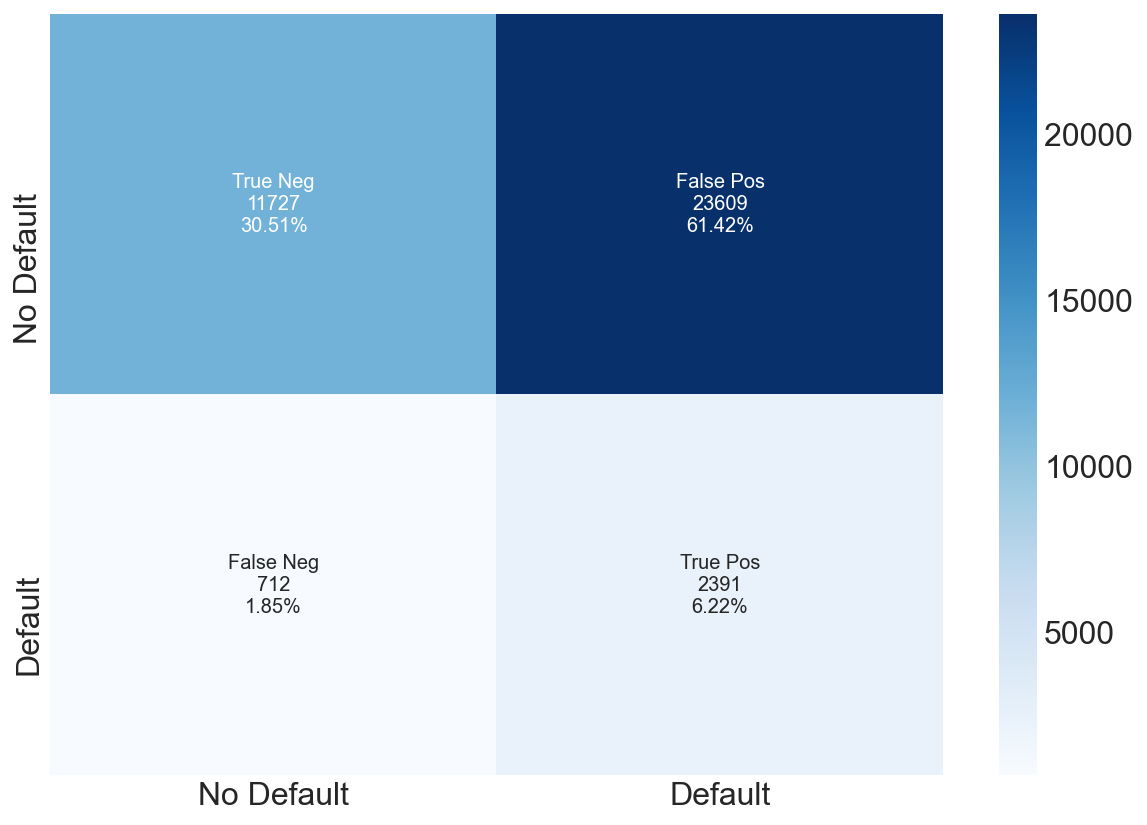

In [150]:
confusion_matrix_normalized(y_test, ada_pred);

From the confusion matrix, we have 28.514 false positives (74.18%). This means that our model predicted that 28.514 people won’t pay back their loans whereas these people actually paid. This is actually bad for business because we will be turning down people that can actually pay back their loans which will mean that we are loosing a certain percentage of our potential customers. Our model also has 3099 (0.79%) false negatives. This means is that our model predicted that these 305 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.3. CatBoost

In [130]:
# https://setscholars.net/wp-content/uploads/2019/02/find-optimal-parameters-using-RandomSearchCV-in-Regression-in-Python.html
catb = CatBoostClassifier(verbose=False, iterations=100, random_state = 2021)
clf_catb = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('catb', catb)])

params_catb = {'catb__learning_rate': sp_randFloat(),
               'catb__subsample'    : sp_randFloat(),
               'catb__max_depth'    : sp_randInt(2, 10),
               'catb__iterations'    : sp_randInt(10, 100),
              }

clf_catb = RandomizedSearchCV(estimator=clf_catb, 
                            param_distributions=params_catb, 
                            cv=2, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)

clf_catb.fit(X_train, y_train);

print('Final score on training-set is: ', clf_catb.score(X_train, y_train))
print('Final score on test-set is: ', clf_catb.score(X_test, y_test))
# Best params
print (' ')
print('\nBest params:\n', clf_catb.best_params_)

Final score on training-set is:  0.5827693629820604
Final score on test-set is:  0.5691266516274573
 

Best params:
 {'catb__iterations': 15, 'catb__learning_rate': 0.20185024783461958, 'catb__max_depth': 4, 'catb__subsample': 0.483519644998729}


In [135]:
final_model_cat = CatBoostClassifier(random_state=2021, 
                                     iterations = 15, 
                                     learning_rate = 0.20185024783461958,
                                     max_depth = 4,
                                     subsample = 0.483519644998729,
                                     verbose = False
                                     )

clf_cat = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('catb', final_model_cat)])

clf_cat.fit(X_train, y_train)

print("Report:")
cat_pred = clf_cat.predict(X_test)
gnb_accuracy = round(metrics.accuracy_score(y_test, cat_pred), 4)
print ('The Accuracy of the CatBoost-model is: {}'.format(gnb_accuracy))
print (' ')
print(classification_report(y_test, cat_pred))

Report:
The Accuracy of the CatBoost-model is: 0.6098
 
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     35336
           1       0.11      0.57      0.19      3103

    accuracy                           0.61     38439
   macro avg       0.53      0.59      0.47     38439
weighted avg       0.87      0.61      0.70     38439



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 0%, a recall rate of 0% and an accuracy score of 92%. To refresh our knowledge of precision, recall and accuracy, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

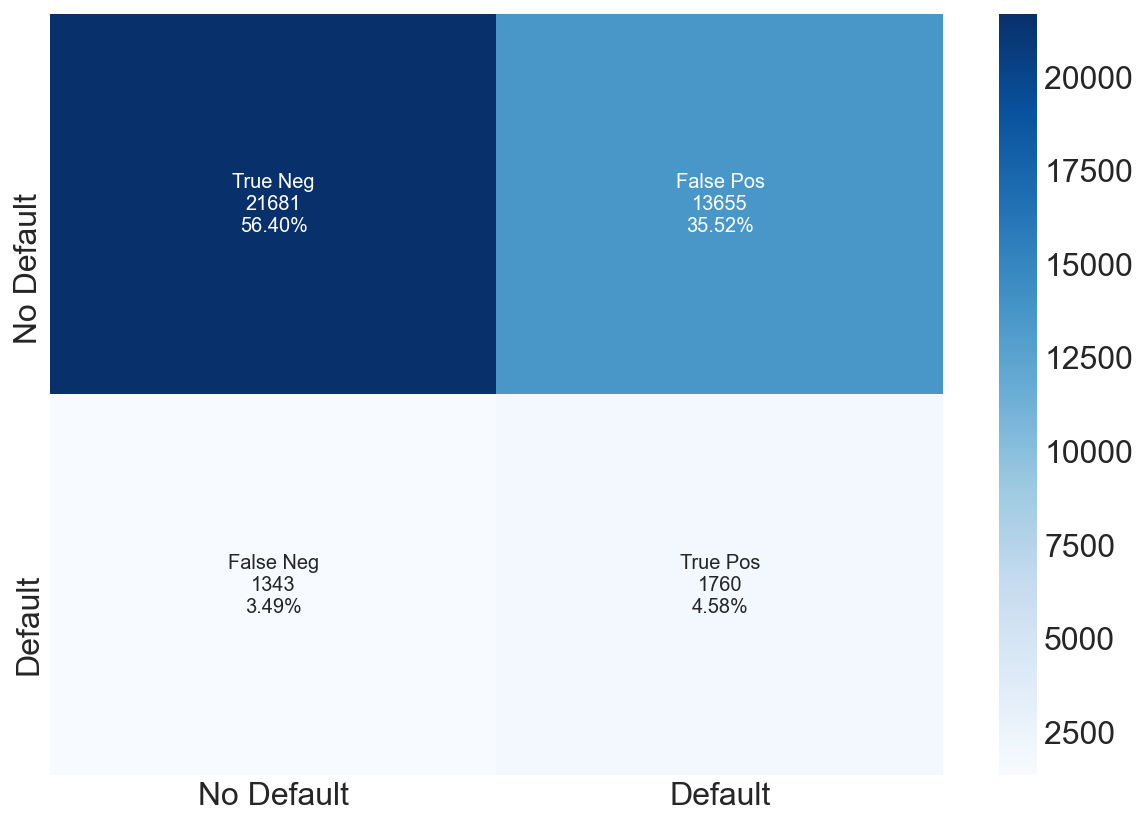

In [136]:
confusion_matrix_normalized(y_test, cat_pred);

From the confusion Matrix, we have 0 false positives (0.00%). This means that our model predicted that 0 people won’t pay back their loans whereas these people actually paid. This is actually good for the bank because it won't be turning down people that can actually pay back their loans which will mean that the bank will not loose any potential customers. Our model also has 3103 false negatives (8.07%). This means is that our model predicted that these 3103 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.4. LGBMClassifier

In [100]:
lgbm = LGBMClassifier(iterations=100, random_state = 2021)
clf_lgbm = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('lgbm', lgbm)])

params_lgbm = {'lgbm__reg__alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
               'lgbm__min__child__weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
               'lgbm__reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
               'lgbm__reg__lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
              }

clf_lgbm = RandomizedSearchCV(estimator=clf_lgbm, 
                            param_distributions=params_lgbm, 
                            cv=5, 
                            scoring= 'recall', 
                            n_jobs = -1, 
                            return_train_score=True, 
                            random_state=2021)

clf_lgbm.fit(X_train, y_train);

print('Final score on training-set is: ', clf_lgbm.score(X_train, y_train))
print('Final score on test-set is: ', clf_lgbm.score(X_test, y_test))
# Best params
print (' ')
print('\nBest params:\n', clf_lgbm.best_params_)

Final score on training-set is:  0.5908260822859598
Final score on test-set is:  0.4814695456010313
 

Best params:
 {'lgbm__reg_alpha': 0.1, 'lgbm__reg__lambda': 50}


In [111]:
# @hidden
final_model_lgbm = LGBMClassifier(reg_alpha=0.1, reg_lambda = 50, random_state=2021)
clf_lgbm = Pipeline([('preprocessor', preprocessor), ('pca', PCA(n_components=40)), ('smt', smt), ('lgbm', final_model_lgbm)])
clf_lgbm.fit(X_train, y_train)
print("Report:")
lgbm_pred = clf_lgbm.predict(X_test)
lgbm_accuracy = round(metrics.accuracy_score(y_test, lgbm_pred), 4)
print ('The Accuracy of the LGBM-model is: {}'.format(lgbm_accuracy))
print (' ')
print(classification_report(y_test, lgbm_pred))

Report:
The Accuracy of the LR-model is: 0.6812
 
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     35336
           1       0.12      0.48      0.20      3103

    accuracy                           0.68     38439
   macro avg       0.53      0.59      0.50     38439
weighted avg       0.87      0.68      0.75     38439



**Interpretation:** <br>
From our classification report we can see that our model has a precision of 36%, a recall rate of 0% and an accuracy score of 92%. To refresh our knowledge of precision, recall and accuracy, this means the following:
- Precision: what proportion of positive identifications was actually correct?
- Recall: what proportion of actual positives were identified correctly?
- Accuracy: is the fraction of predictions the model got right

A more in-depth overview gives the following confusion-matrix:

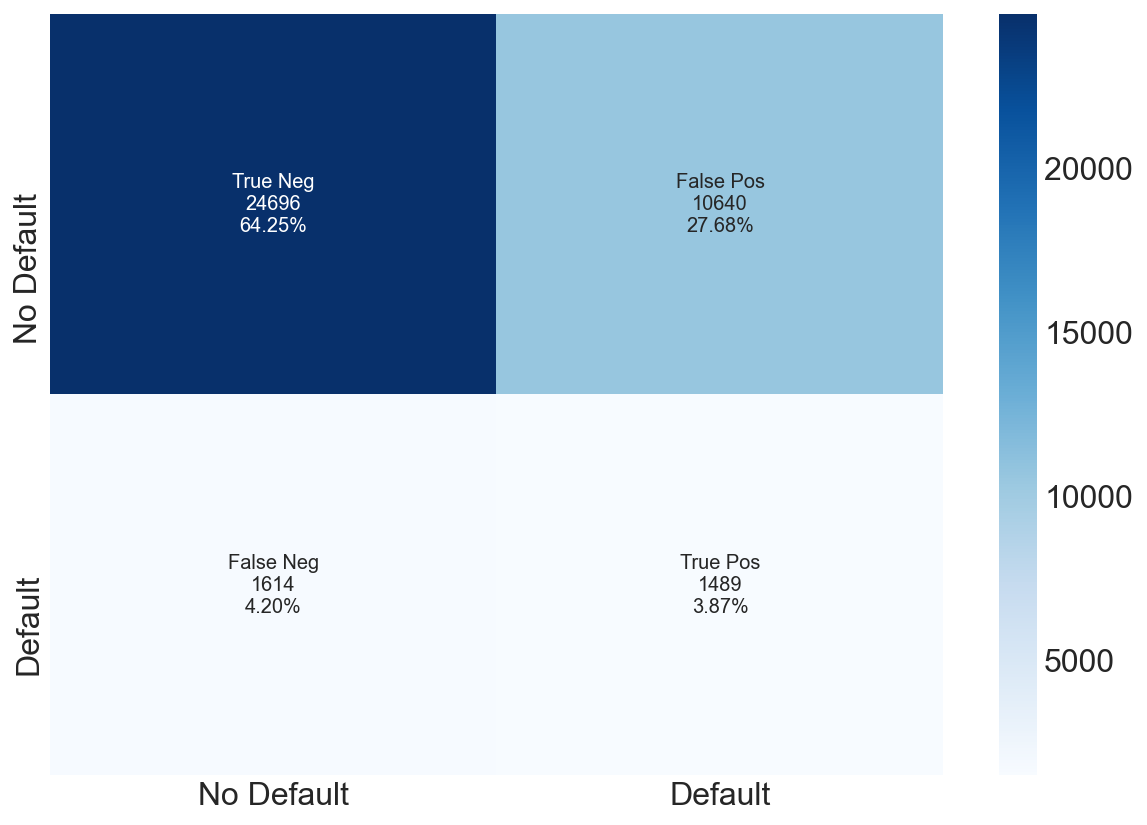

In [112]:
# @hidden
confusion_matrix_normalized(y_test, lgbm_pred);

From the confusion matrix, we have 7 false positives (0.02%). This means that our model predicted that 7 people won’t pay back their loans whereas these people actually paid. This is actually bad for business because we will be turning down people that can actually pay back their loans which will mean that we are loosing a certain percentage of our potential customers.
Our model also has 3099 (8.06%) false negatives. This means is that our model predicted that these 3099 people will pay back their loans (i.e. won't default), whereas in reality they defaulted on their loans. This is also bad for business since it is not in the interest of the bank to approve loans to customers, who in the end, are unable to pay back their loan. 

#### 5.5. Pickle the models

In order to work with our models, it is important to save the predictions to a file, and then restore them in order to reuse it for later. This saving procedure is also known as object serialization - representing an object with a stream of bytes, in order to store it on disk, send it over a network or save to a database, while the restoring procedure is known as deserialization [3]. One possible approach, is to use the library **pickle**.

In [151]:
# @hidden
##########################################
############ Save the models #############
##########################################

# save: logistic regression
#pickle_logreg = "log_reg.pkl"
#with open(pickle_logreg, 'wb') as file:
#    pickle.dump(final_model_logreg, file)
    
# save: naive bayes
pickle_ada = "ada_boost.pkl"
with open(pickle_ada, 'wb') as file:
    pickle.dump(final_model_ada, file)
    
# save: lgbm
pickle_lgbm = "lgbm.pkl"
with open(pickle_lgbm, 'wb') as file:
    pickle.dump(final_model_lgbm, file)
    
# save: catboost
pickle_cat = "cat_boost.pkl"
with open(pickle_cat, 'wb') as file:
    pickle.dump(final_model_cat, file)

In [6]:
# @hidden
##########################################
############ Load the models #############
##########################################
# https://stackoverflow.com/questions/61786481/why-cant-i-read-a-joblib-file-from-my-github-repo

# load: logistic regression
logreg_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/log_reg.pkl?raw=true'
logreg_model_link = BytesIO(requests.get(logreg_model_link).content)
pickle_logreg = pickle.load(logreg_model_link)

# load: catboost
cat_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/cat_boost.pkl?raw=true'
cat_model_link = BytesIO(requests.get(cat_model_link).content)
pickle_cat = pickle.load(cat_model_link)

# load: lgbm
lgbm_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/lgbm.pkl?raw=true'
lgbm_model_link = BytesIO(requests.get(lgbm_model_link).content)
pickle_lgbm = pickle.load(lgbm_model_link)

# load: naive bayes
nb_model_link = 'https://github.com/ThomasD96/NovaSBE_Machine_Learning/blob/main/pickled_models/naive_bayes.pkl?raw=true'
nb_model_link = BytesIO(requests.get(nb_model_link).content)
pickle_nb = pickle.load(nb_model_link)

#### 5.6. Model Comparisons & Threshold Fitting

##### ROC-curves

AUC-ROC curve is a performance metric for binary classification problem at different thresholds. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much model is capable of distinguishing between classes. The ideal ROC curve would be at the top left-hand corner of the image at a TPR of 1.0 and FPR of 0.0. Or in other words, ROC tells us to what extent the model is capable of distinguishing between classes. The higher the AUC, the better the model is at predicting 0s as 0s and 1s as 1s. By looking at the plot below, all of our models are quite above average as they are above the basic threshold which is the black dashed line.

The ROC curve is plotted with TPR (True Positive Rate, which is True Positive / [True Positive + False Negative]) against the FPR (False Positive Rate, which is [False Positive / False Positive + True Negative]) where TPR is on the y-axis and FPR is on the x-axis. ROC, other than accuracy, is widely used in imbalanced data. This is the case for credit default risk prediction because it is a combination of precision and recall.

Plotting multiple ROC-Curves in a single figure makes it easier to analyze model performances and find out the best performing model.

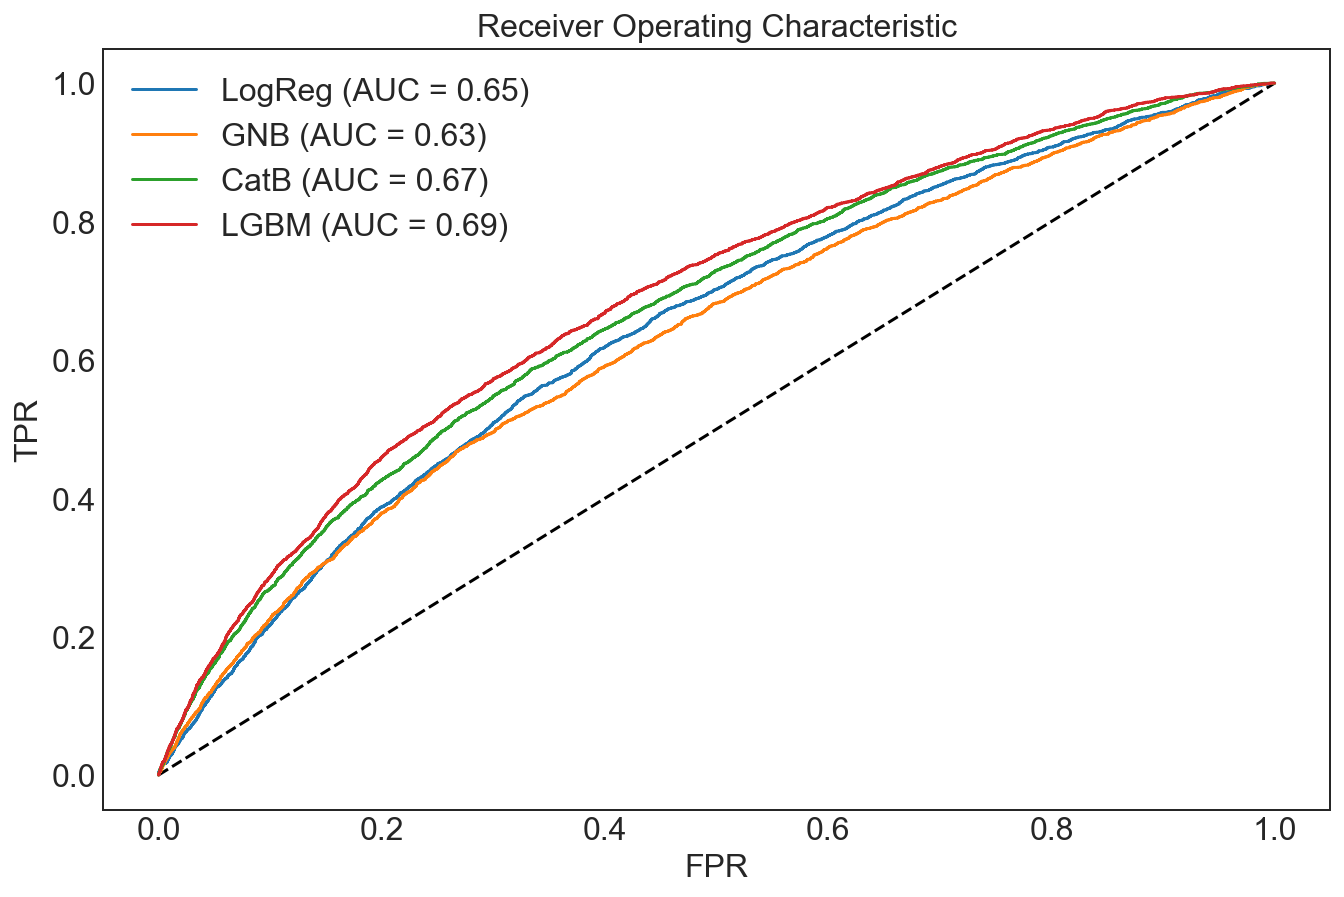

In [101]:
plt.rcParams["figure.figsize"] = (11,7)
#logreg_pred_proba = pickle_logreg_load.predict_proba(X_test_smote)[:,1]
#fpr1 , tpr1, thresholds1 = roc_curve(y_test_smote, logreg_pred_proba)
#auc_roc_logreg = metrics.roc_auc_score(y_test_smote, logreg_pred_proba)

ada_pred_proba = pickle_nb_load.predict_proba(X_test)[:,1]
fpr2 , tpr2, thresholds2 = roc_curve(y_test, ada_pred_proba)
auc_roc_gnb = metrics.roc_auc_score(y_test, ada_pred_proba)

cat_pred_proba = pickle_cat_load.predict_proba(X_test_smote)[:,1]
fpr3 , tpr3, thresholds3 = roc_curve(y_test_smote, cat_pred_proba)
auc_roc_cat = metrics.roc_auc_score(y_test_smote, cat_pred_proba)

lgbm_pred_proba = pickle_lgbm_load.predict_proba(X_test_smote)[:,1]
fpr4 , tpr4, thresholds4 = roc_curve(y_test_smote, lgbm_pred_proba)
auc_roc_lgbm = metrics.roc_auc_score(y_test_smote, lgbm_pred_proba)

plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label = 'LogReg (AUC = %0.2f)' % auc_roc_logreg)
plt.plot(fpr2, tpr2, label = 'GNB (AUC = %0.2f)' % auc_roc_gnb)
plt.plot(fpr3, tpr3, label = 'CatB (AUC = %0.2f)' % auc_roc_cat)
plt.plot(fpr4, tpr4, label = 'LGBM (AUC = %0.2f)' % auc_roc_lgbm)
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

**Interpretation of ROC-curve**:<br>


##### Threshold Optimization for the best classifier

The decision for converting a predicted probability or scoring into a class label is governed by a parameter referred to as the “decision threshold,” “discrimination threshold,” or simply the “threshold.” The default value for the threshold is 0.5 for normalized predicted probabilities or scores in the range between 0 or 1.

For instance, for our kind problem, credit default prediction, we have to decide that all customers whose score is above a certain threshold should not be granted a loan or should be investigated more thoroughly, which will review each case indepently. 

In general, for a binary classification problem with class labels 0 and 1, normalized predicted probabilities and a threshold of 0.5, then values less than the threshold of 0.5 are assigned to class 0 and values greater than or equal to 0.5 are assigned to class 1.
- Prediction < 0.5 = Class 0
- Prediction >= 0.5 = Class 1

The problem is that the default threshold may not represent an optimal interpretation of the predicted probabilities. Thus, in order to overcome this issue, we are using the **G-mean** to find the optimal threshold value for our classification model, which, if optimized correctly, will seek a balance between the sensitivity and the specificity. The G-Mean is defined as follows [4]:
- G-Mean = sqrt(Sensitivity * Specificity)

Best Threshold: 0.0952 with G-Mean: 0.6366
FPR: 0.3619, TPR: 0.6352


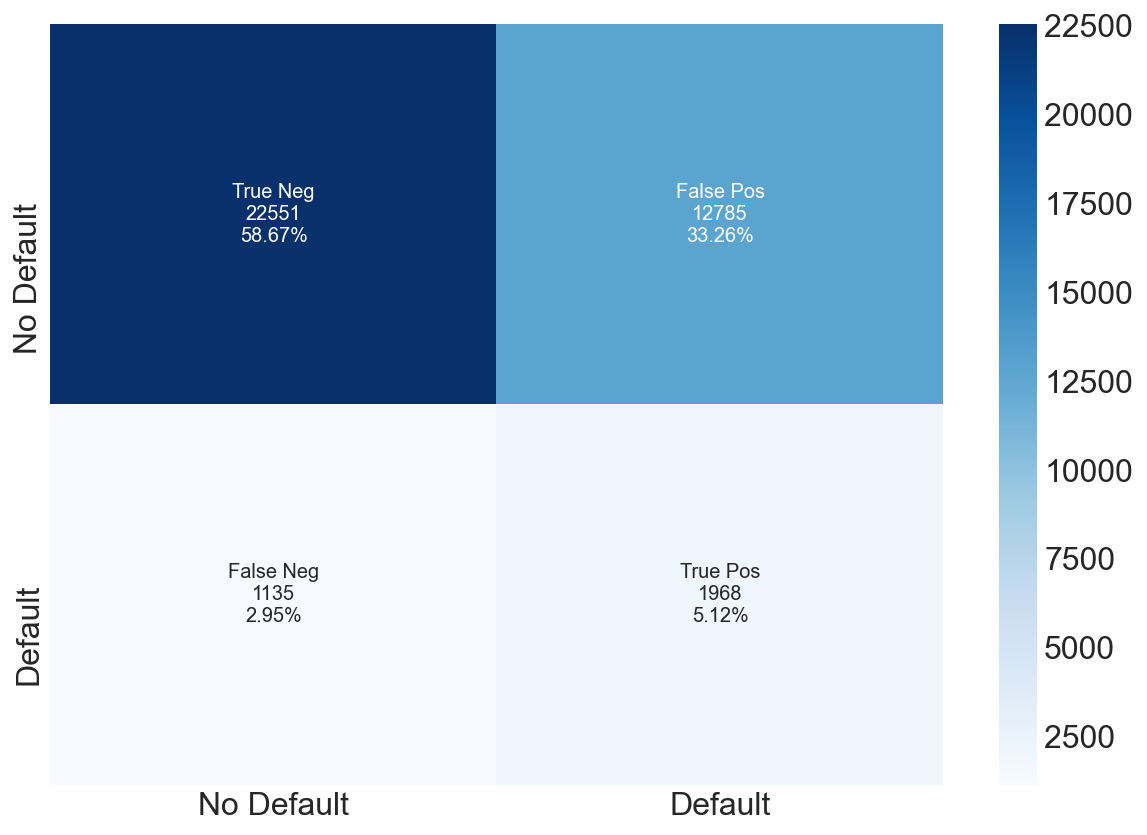

In [158]:
# get threshold for LGBM
lgbm_threshold = threshold_optimizer(y_test_smote, lgbm_pred_proba);

# Plot confusion matrix for LGBM with optimized threshold
pred_threshold = makePredThresh(pickle_lgbm_load, thr=lgbm_threshold, X_test = X_test_smote)
confusion_matrix_normalized(y_test_smote, pred_threshold);

Using the G-mean as the unbiased evaluation metrics and the main focus of threshold moving, it produces the optimal threshold for the binary classification of 0.0952. Theoretically, the observation will be categorized as a minor class when its probability is lower than 0.0952, vice versa.

Best Threshold: 0.1161 with G-Mean: 0.6251
FPR: 0.3345, TPR: 0.5872


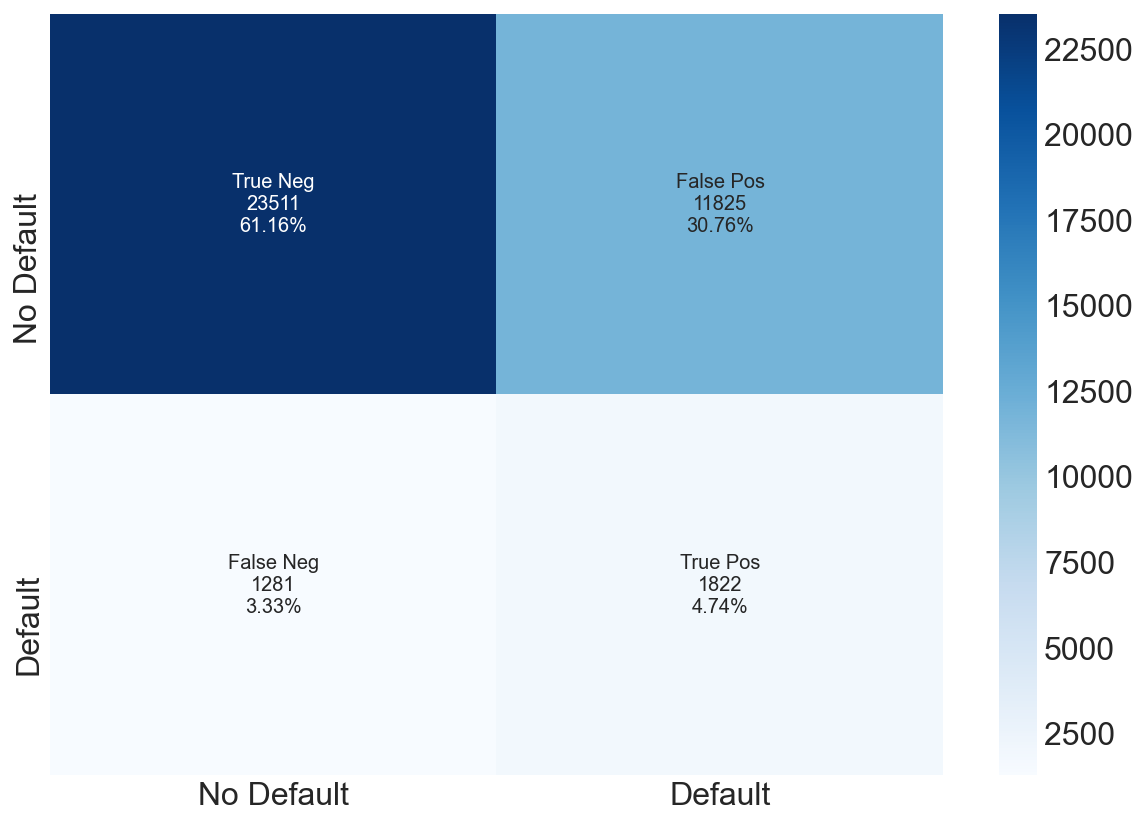

In [157]:
# get threshold for CatBoost
cat_threshold = threshold_optimizer(y_test_smote, cat_pred_proba);

# Plot confusion matrix for CatBoost with optimized threshold
pred_threshold = makePredThresh(pickle_cat_load, thr=cat_threshold, X_test = X_test_smote)
confusion_matrix_normalized(y_test_smote, pred_threshold);

Using the G-mean as the unbiased evaluation metrics and the main focus of threshold moving, it produces the optimal threshold for the binary classification of 0.1161. Theoretically, the observation will be categorized as a minor class when its probability is lower than 0.1161, vice versa.

Best Threshold: 0.493 with G-Mean: 0.6102
FPR: 0.3944, TPR: 0.6149


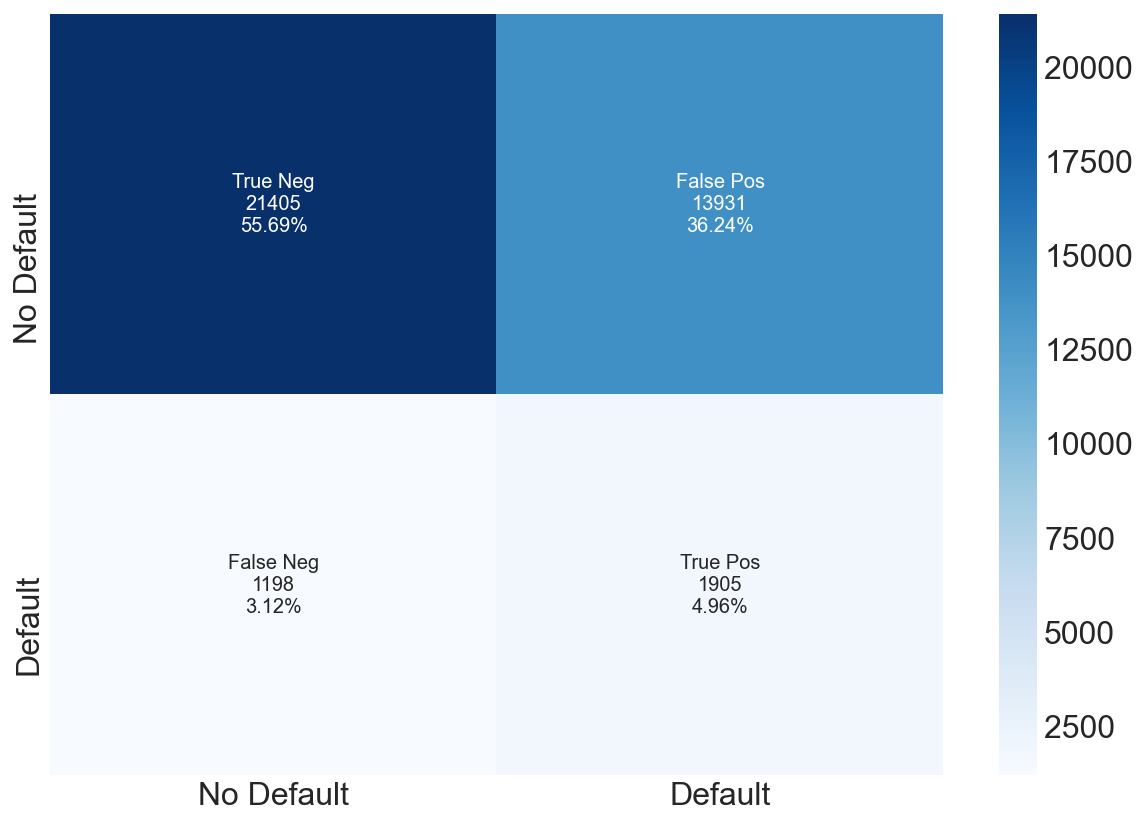

In [156]:
# get threshold for LogReg
logreg_threshold = threshold_optimizer(y_test_smote, logreg_pred_proba);

# Plot confusion matrix for LogReg with optimized threshold
pred_threshold = makePredThresh(pickle_logreg_load, thr=logreg_threshold, X_test = X_test_smote)
confusion_matrix_normalized(y_test_smote, pred_threshold);

Using the G-mean as the unbiased evaluation metrics and the main focus of threshold moving, it produces the optimal threshold for the binary classification of 0.493. Theoretically, the observation will be categorized as a minor class when its probability is lower than 0.493, vice versa.

#### 5.7. Test final (tuned) model on holdout set

In section 4.2, we divided our main dataset into three parts:
- train set
- test set
- holdout/validation set

In this section, we are evaluating the final model, i.e. our best classifier from above, with the third dataset to see how well the model actually performs on unseen data which ultimately should provide us with an unbiased evaluation of the fitted model.

In [165]:
# remove ID and TARGET from validation_set
validation_set_prediction = validation_set.drop(['SK_ID_CURR', 'TARGET'], 1)

# create y_validation (TARGET-class)
y_validation_set = validation_set['TARGET'].values

In [169]:
# apply fitted LGBM model 
lgbm_pred_validation = clf_lgbm.predict(validation_set_prediction)
lgbm_accuracy_validation = round(metrics.accuracy_score(y_validation_set, lgbm_pred_validation), 4)
print ('The Accuracy of the LGBM-model is: {}'.format(lgbm_accuracy_validation))
print (' ')
print(classification_report(y_validation_set, lgbm_pred_validation))

The Accuracy of the LGBM-model is: 0.6884
 
              precision    recall  f1-score   support

           0       0.94      0.70      0.81    141343
           1       0.13      0.51      0.21     12413

    accuracy                           0.69    153756
   macro avg       0.54      0.61      0.51    153756
weighted avg       0.88      0.69      0.76    153756



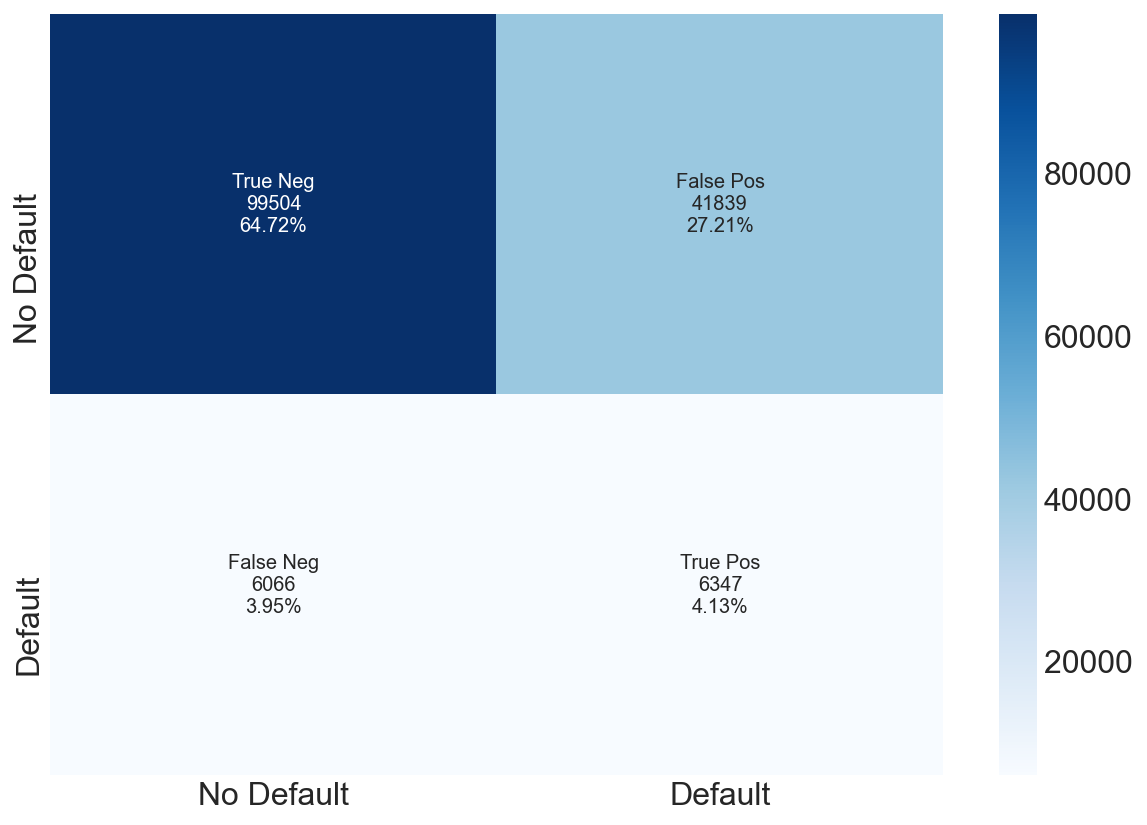

In [170]:
confusion_matrix_normalized(y_validation_set, lgbm_pred_validation);

### 6. References

[1] https://towardsdatascience.com/building-an-automated-machine-learning-pipeline-part-one-5c70ae682f35<br>
[2] https://medium.com/aiplusoau/hyperparameter-tuning-a5fe69d2a6c7 <br>
[3] https://stackabuse.com/scikit-learn-save-and-restore-models/<br>
[4] https://towardsdatascience.com/optimal-threshold-for-imbalanced-classification-5884e870c293<br>
[5] https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/<br>
[6] https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/<br>
[7] https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc